# Initialisations

In [1]:
library(rJava)
library(ggplot2)
library(corrplot)
library(cluster)
library(reshape2)
library(factoextra)
library(xlsx)
library(dtw)
library(rpart.plot)
library(rpart)
theme_set(theme_classic())

corrplot 0.84 loaded
Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Loading required package: xlsxjars
Loading required package: proxy

Attaching package: ‘proxy’

The following objects are masked from ‘package:stats’:

    as.dist, dist

The following object is masked from ‘package:base’:

    as.matrix

Loaded dtw v1.18-1. See ?dtw for help, citation("dtw") for use in publication.

Loading required package: rpart


# Plot Functions

In [2]:
#On crée des fonctions pour faires des barplots et boxplots tout au long du projet.
adenome_boxplot <- function(df, feature_index, title){
  x_axis = colnames(df)[feature_index]

  g <- ggplot(df, aes("", df[,feature_index]))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle=x_axis,
         x=x_axis,
         y="")
  print(g)
}

adenome_boxplot_couple <- function(df, feature_1, feature_2, f1, f2){
  x_axis = f1
  y_axis = f2
  title = paste(x_axis, " Vs. ", y_axis)
    
  g <- ggplot(df, aes(x = feature_1, y = feature_2))
  g <- g + geom_boxplot(varwidth=T, fill="plum")
  g <- g + labs(title=title, 
         subtitle="",
         x=x_axis,
         y=y_axis)
    
  print(g)
}

adenome_scatterplot <- function(df, feature_1, feature_2, f1, f2) {
  x_axis = f1
  y_axis = f2
  title = "VAPOR"
  subtitle = paste(x_axis, " Vs. ", y_axis)
  g <- ggplot(df, aes(x=feature_1, y=feature_2))
  g <- g + geom_point()
  g <- g + labs(title=title,y=y_axis,x=x_axis)
  print(g)
}

adenome_barplot <- function(df, feature_index, title) {
  x_axis = colnames(df)[feature_index]
  g <- ggplot(df, aes(df[,feature_index]))
  g <- g + geom_bar(width = 0.15,fill = c("#FF6666"))+theme_bw()
  g <- g + labs(title=title, 
         subtitle=x_axis,
         x=x_axis,
         y="")
  print(g)
}

adenome_piechart <- function(df, feature_index, title){
  bar <- ggplot(vapor, aes(x="", fill = factor(df[,feature_index]))) + geom_bar(width = 1)
  pie <- bar + coord_polar(theta = "y")
  print(pie)
}

# Obtenir le triangle inférieur d'une matrice
get_lower_tri <- function(mat){
    mat[upper.tri(mat)] <- NA
    return(mat)
}

# Obtenir le triangle supérieur d'une matrice
get_upper_tri <- function(mat){
    mat[lower.tri(mat)] <- NA
    return(mat)
}

# Re-ordonne la matrice de corrélation
reorder_cormat <- function(cormat){
    # Utiliser la corrélation entre les variables
    # comme mesure de distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <- cormat[hc$order, hc$order]
}

adenome_heatmap <- function(cormat) { 
    # Reordonner la matrice de corrélation
    cormat <- reorder_cormat(cormat)
    upper_tri <- get_upper_tri(cormat)
    # Fondre la matrice de corrélation
    melted_cormat <- melt(upper_tri, na.rm = TRUE)
    # Créer le heatmap
    ggheatmap <- ggplot(melted_cormat, aes(Var2, Var1, fill = value))+
        geom_tile(color = "white")+
        scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
        midpoint = 0, limit = c(-1,1), space = "Lab",
        name="Pearson\nCorrelation") +
        theme_minimal()+ # minimal theme
        theme(axis.text.x = element_text(angle = 45, vjust = 1, 
        size = 12, hjust = 1))+
        coord_fixed()
    
ggheatmap <- ggheatmap + 
    geom_text(aes(Var2, Var1, label = round(value,3)), color = "black", size = 3) +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))
    
    # Afficher heatmap
    print(ggheatmap)
}

# Cleanup & Data Preparation

## Pré-traitements


### Préparation des datasets

Afin de pouvoir utiliser les fichiers donnés on procède à un traitement des donnéeset à une lecture des fichiers. On effet certaines données qui sont catgéoriques sont transformés en type factor, les données booléennes dont de type logical. 

In [3]:
# import du fichier complet
vapor <- read.xlsx(file = "datasets/VAPOR.xlsx", sheetIndex = 1, header = 1, startRow = 2)[,-1]
attributes(vapor)$names = c('Age','Comorbidite','Duree_Traitement_Medical','Porteur_Sonde','IPSS','QoL','Qmax','PSA','Volume_Prostatique','Residu_post_mictionnel','Indication','Anesthesie','Evenement','Technique','Transfusion','Temps_Operation','Volume_Reseque','Delai_Ablation','Caillotage','Reprise_Bloc',
    'X1M_IPSS','X1M_QoL','X1M_Qmax','X3M_IPSS','X3M_QoL','X3M_Qmax','X6M_IPSS','X6M_QoL','X6M_Qmax','X9M_IPSS','X9M_QoL','X9M_Qmax','X12M_IPSS','X12M_QoL','X12M_Qmax','X15M_IPSS','X15M_QoL','X15M_Qmax','X18M_IPSS','X18M_QoL','X18M_Qmax')

# Cast des variables booléennes
vapor$Comorbidite<-as.logical(vapor$Comorbidite)
vapor$Porteur_Sonde<-as.logical(vapor$Porteur_Sonde)
vapor$Transfusion<-as.logical(vapor$Transfusion)
vapor$Caillotage<-as.logical(vapor$Caillotage)
vapor$Reprise_Bloc<-as.logical(vapor$Reprise_Bloc)

# Cast des variables catégoriques
vapor$Indication<-as.factor(vapor$Indication)
vapor$Anesthesie<-as.factor(vapor$Anesthesie)
vapor$Evenement<-as.factor(vapor$Evenement)
vapor$Technique<-as.factor(vapor$Technique)

# Cast des variables catégoriques ordonnées
vapor$QoL<-as.ordered(vapor$QoL)
vapor$X1M_QoL<-as.ordered(vapor$X1M_QoL)
vapor$X3M_QoL<-as.ordered(vapor$X3M_QoL)
vapor$X6M_QoL<-as.ordered(vapor$X6M_QoL)
vapor$X9M_QoL<-as.ordered(vapor$X9M_QoL)
vapor$X12M_QoL<-as.ordered(vapor$X12M_QoL)
vapor$X15M_QoL<-as.ordered(vapor$X15M_QoL)
vapor$X18M_QoL<-as.ordered(vapor$X18M_QoL)
# 20 premières colonnes du dataset -> pré-opératoire et les dernières -> post-opératoire
vapor_pre<-vapor[,1:20]
vapor_post<-vapor[,21:41]

# On crée un dataframe ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
vapor_num <- vapor[,sapply(vapor, function(x) is.numeric(x))]
vapor_num_pre = vapor_num[1:10]
vapor_num_post = vapor_num[11:24]


# 1.Considérations

Pour faire une analyse décriptive complète il faut que tout les champs de toutes les variables soit renseignés. Cependant pour la variable'Residu post mictionnel' certains individus ont des valeurs non renseignée.Deux possibilités se présentent : 
-Supprimer tout les individus ayant la variable non renseignée 
ou 
-Suprimer la varible 'Residu post mictionnel'.
Pour celà il va falloir étudier si la suppression de cette variable n'a aucun impact sur notre étude .

Ainsi on crée une matrice de corrélation sur les varibles numériques de vapor en enlevant les individus ayant un résidu post mictionnel non défini.

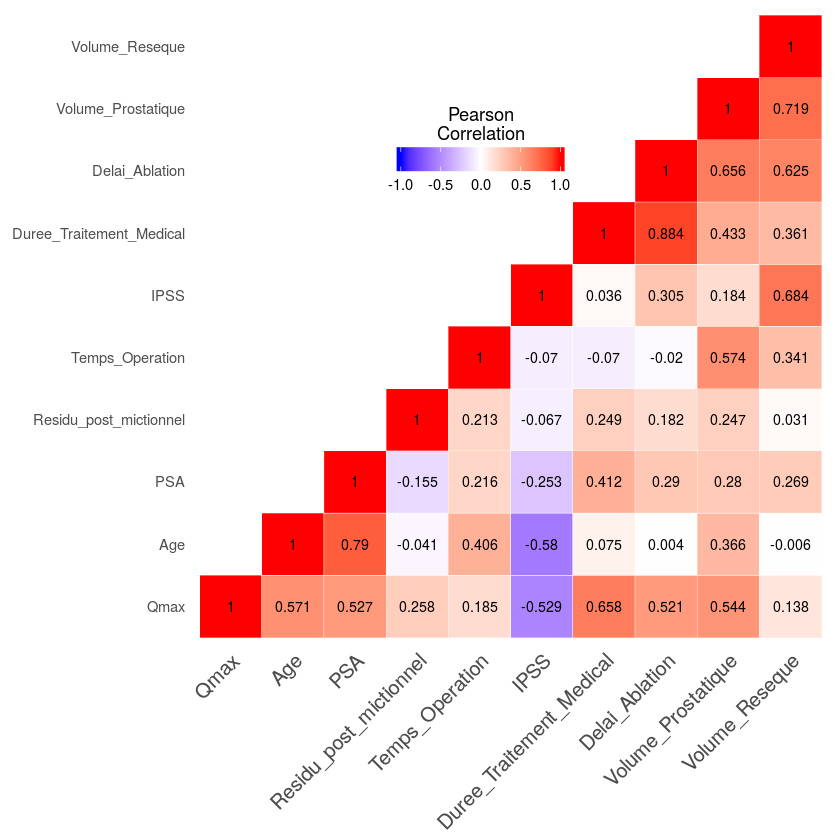

In [4]:
#Faut il garder le résidu post  ou l'enlever ? 
#On enlève tout les individus ayant un résidu post mictionnel=NA
vapor_num_pre_sans= subset(vapor_num_pre[which(vapor_num_pre$Residu_post_mictionnel != ""),])

mat_cor_vapoor_num_pre = cor(vapor_num_pre_sans, method = c("pearson"))
adenome_heatmap(mat_cor_vapoor_num_pre )
   


Ainsi en créant une matrice de corrélation sans les individus ayant  le 'Residu post mictionnel' non définit  c'est-à-dire on enlève tout les individu porteurs de sonde et on retrouve la matrice de corrélation ci-dessus. On peut déduire que la variable 'Residu post mictionnel' n'est corrélée à aucune autre variable et donc on peut déduire qu'elle peut être une composante intéréssante à garder pour notre étude. On peut également faire une ACP pour confirmer l'intêret de garder cette variable dans notre jeu de données. 

Ainsi on fait une analyse en composantes principales sur les varibles numériques de vapor en enlevant les individus ayant un résidu post mictionnel non défini.

In [5]:
pca <- stats::prcomp(x=subset(vapor_num_pre_sans))
pca

Standard deviations (1, .., p=10):
 [1] 82.3761900 45.3519460 30.8705182 14.1301673  8.7210982  4.5378011
 [7]  1.7928051  0.4590084  0.2340374  0.1108089

Rotation (n x k) = (10 x 10):
                                   PC1         PC2          PC3         PC4
Age                       0.0004453695 -0.02814998  0.040427863 -0.22188161
Duree_Traitement_Medical -0.1738273414 -0.69571824 -0.680800063 -0.05596573
IPSS                      0.0023480168 -0.02318152  0.032575620  0.25394657
Qmax                     -0.0098944784 -0.03081499 -0.011874643 -0.08353452
PSA                       0.0017865406 -0.01767210 -0.004844929 -0.01895752
Volume_Prostatique       -0.1480696991 -0.58726276  0.610579270 -0.35830493
Residu_post_mictionnel   -0.9723380552  0.22679754  0.009450218  0.04962941
Temps_Operation          -0.0370559596 -0.05711579  0.266986419 -0.25107305
Volume_Reseque           -0.0303729499 -0.33667792  0.299036015  0.82572676
Delai_Ablation           -0.0039574939 -0.02134369 -0.

Ainsi en faisant l'ACP on voit clairement que le 'Résidu post mictionnel' a une grande influence sur la PC1 . Ceci nous confirme le fait de devoir garder cette varaible pour la suite de notre étude et de supprimer les individus qui n'en possèdent pas.

On remarque que le 'Residu post mictionnel ' est lié à d'autres variables. On le montre à travers les boxplots ci-dessous.

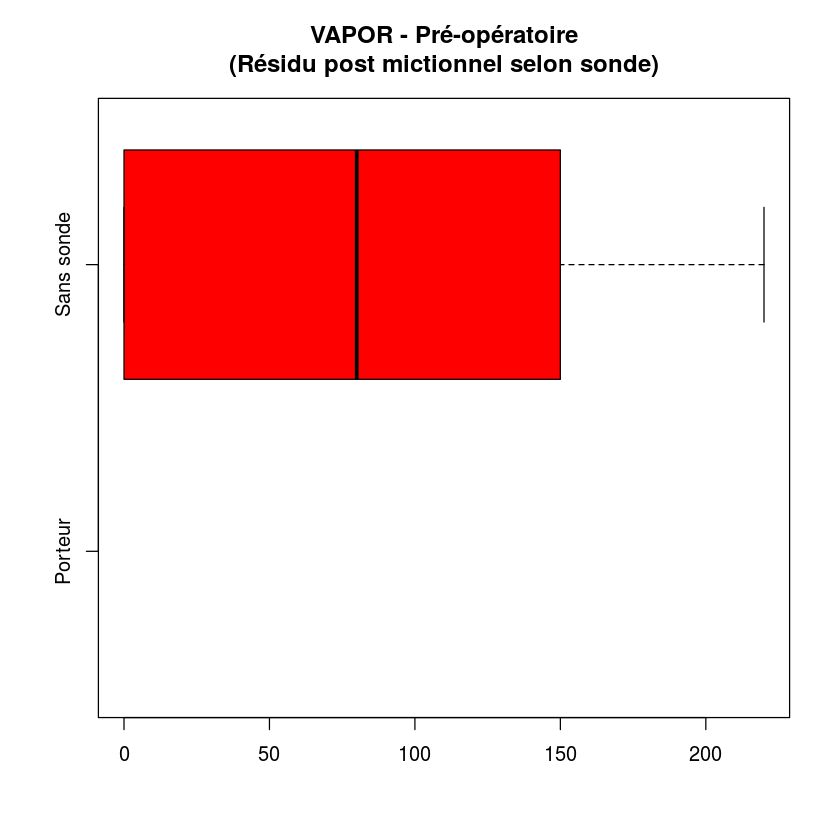

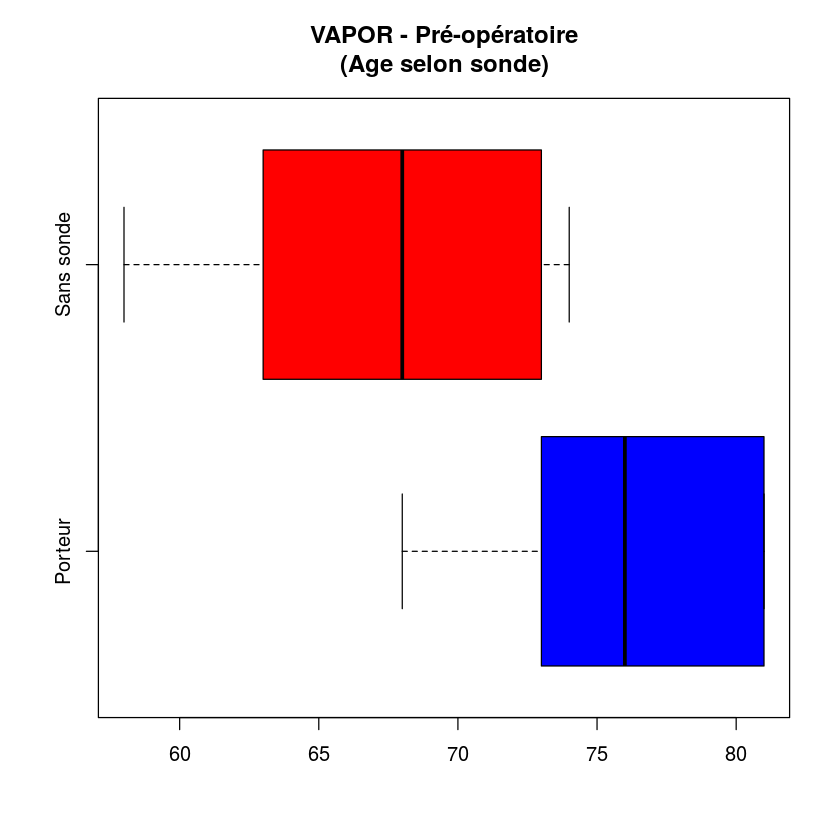

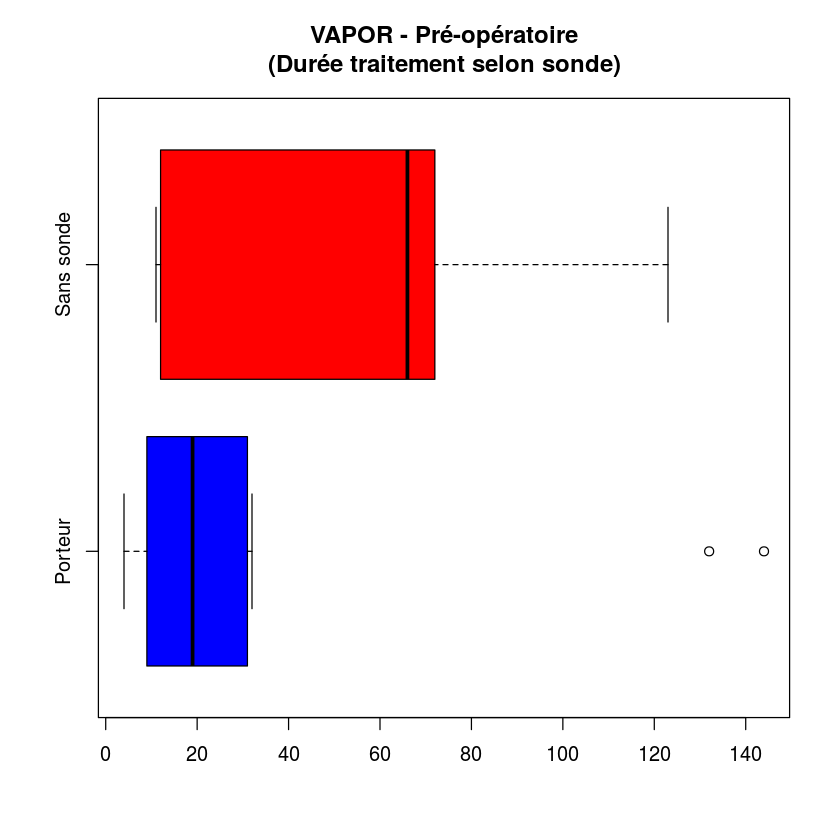

In [6]:
# Quelques distributions par rapport aux porteurs de sondes
boxplot(vapor_pre[which(vapor_pre$Porteur_Sonde == 1),'Residu_post_mictionnel'], vapor_pre[which(vapor_pre$Porteur_Sonde == 0),'Residu_post_mictionnel'], names=c("Porteur","Sans sonde"),horizontal=TRUE,main="VAPOR - Pré-opératoire\n(Résidu post mictionnel selon sonde)", col=c("blue","red"))
boxplot(vapor_pre[which(vapor_pre$Porteur_Sonde == 1),'Age'], vapor_pre[which(vapor_pre$Porteur_Sonde == 0),'Age'], names=c("Porteur","Sans sonde"),horizontal=TRUE,main="VAPOR - Pré-opératoire\n(Age selon sonde)", col=c("blue","red"))
boxplot(vapor_pre[which(vapor_pre$Porteur_Sonde == 1),'Duree_Traitement_Medical'], vapor_pre[which(vapor_pre$Porteur_Sonde == 0),'Duree_Traitement_Medical'], names=c("Porteur","Sans sonde"),horizontal=TRUE,main="VAPOR - Pré-opératoire\n(Durée traitement selon sonde)", col=c("blue","red"))

Ainsi grace aux boxplots ci-dessus on remarque que uniquement les individus non porteurs de sonde ont un résidu post mictionnel défini. 
Les individus porteurs de sonde sont les plus agés. Et les porteurs de sonde ont un traitement moins long. On peut donc déduire que la variable 'Porteur de sonde' est corrélée aux variables 'Age' et 'Durée de traitement'. 
Nous faisons donc le choix de supprimer les individus porteurs de sonde.

On supprime également la varible 'Technique' car elle est représentée par la même valeur chez tous les individus. Cette variable n'apporte donc pas grand chose à notre jeu de données.

# 1. Analyse Descriptive
## 1.1 Pré-opératoire
### 1.1.1 Distributions

In [7]:

vapor=vapor[which(vapor$Porteur_Sonde == FALSE),]
vapor= subset(vapor,select=-c(Porteur_Sonde,Technique))
# 20 premières colonnes du dataset sont donnees pré-opératoire et les dernièrespost-opératoire
vapor_pre<-vapor[,1:18]
vapor_post<-vapor[,19:39]
# On crée un dataframe ne comportant que les variables numériques (pour corrélation linéaire de Pearson)
vapor_num <- vapor[,sapply(vapor, function(x) is.numeric(x))]
vapor_num_pre = vapor_num[1:10]
vapor_num_post = vapor_num[11:24]

# On crée un dataframe ne comportant que les données booléennes, ordinales ou catégoriques
vapor_cat <- vapor[,sapply(vapor, function(x) is.ordered(x) | is.factor(x) | is.logical(x))]
vapor_cat = subset(vapor,select=c(Comorbidite,QoL,Indication,Evenement,Anesthesie,Transfusion,Caillotage,Reprise_Bloc,X1M_QoL,X3M_QoL,X6M_QoL,X9M_QoL,X12M_QoL,X15M_QoL,X18M_QoL))
vapor_cat_pre = vapor_cat[1:8]
vapor_cat_post = vapor_cat[9:15]

Pour avoir une vision plus claire des médianes de nos variables et connaître leur valeur moyenne, on choisit de faire des boxplots.

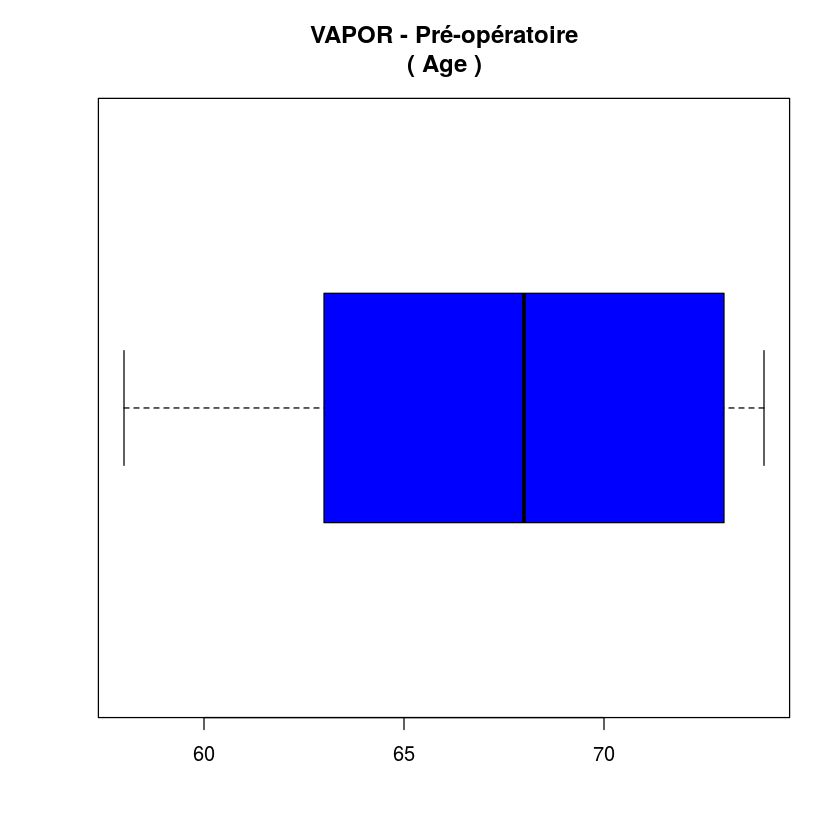

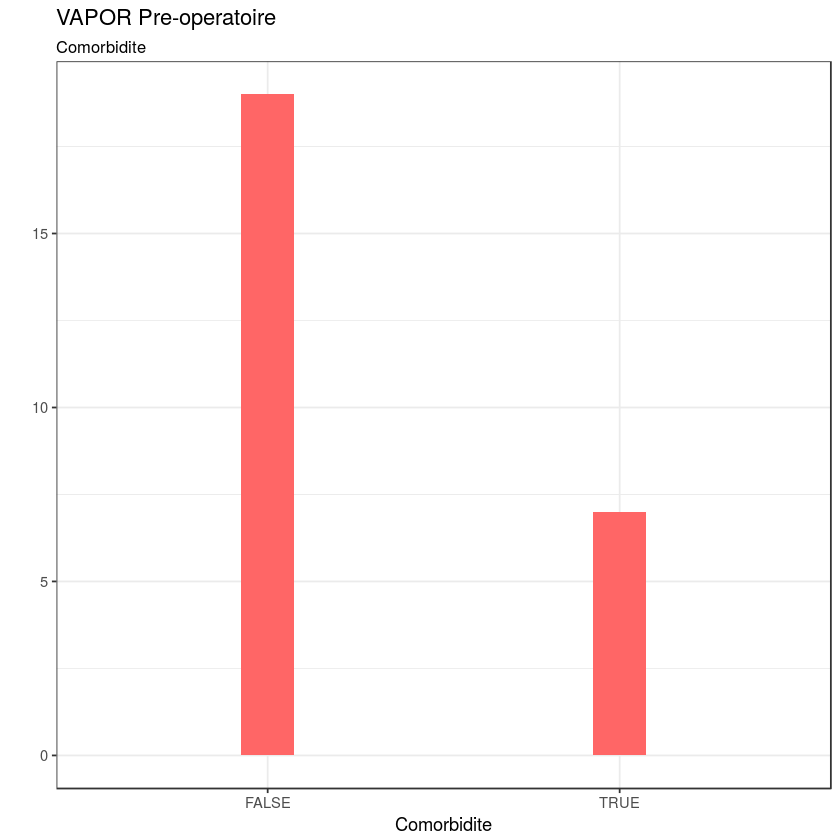

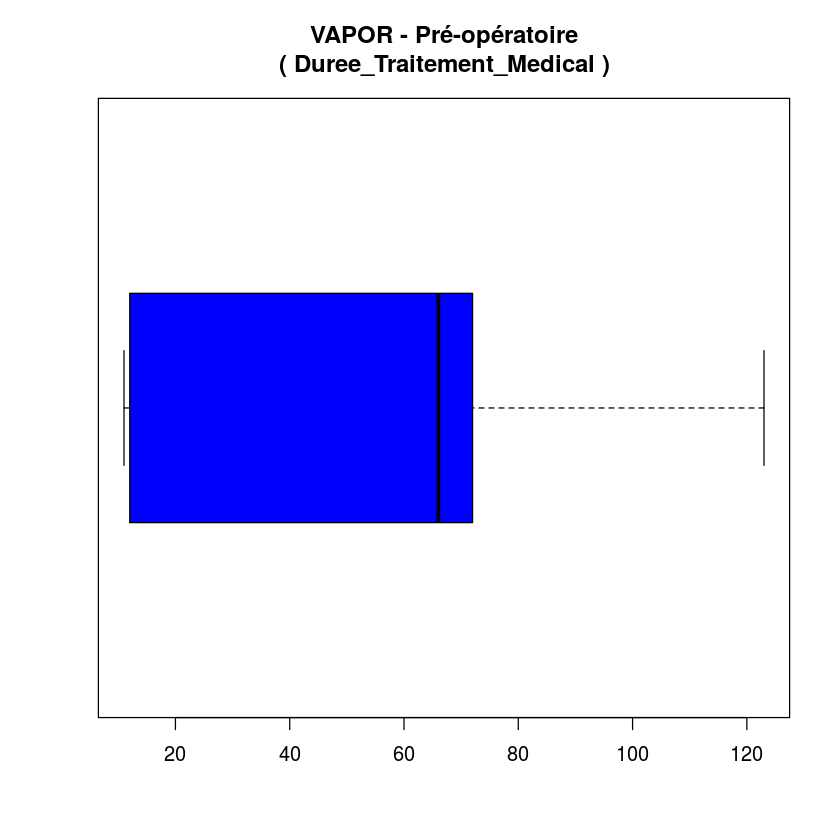

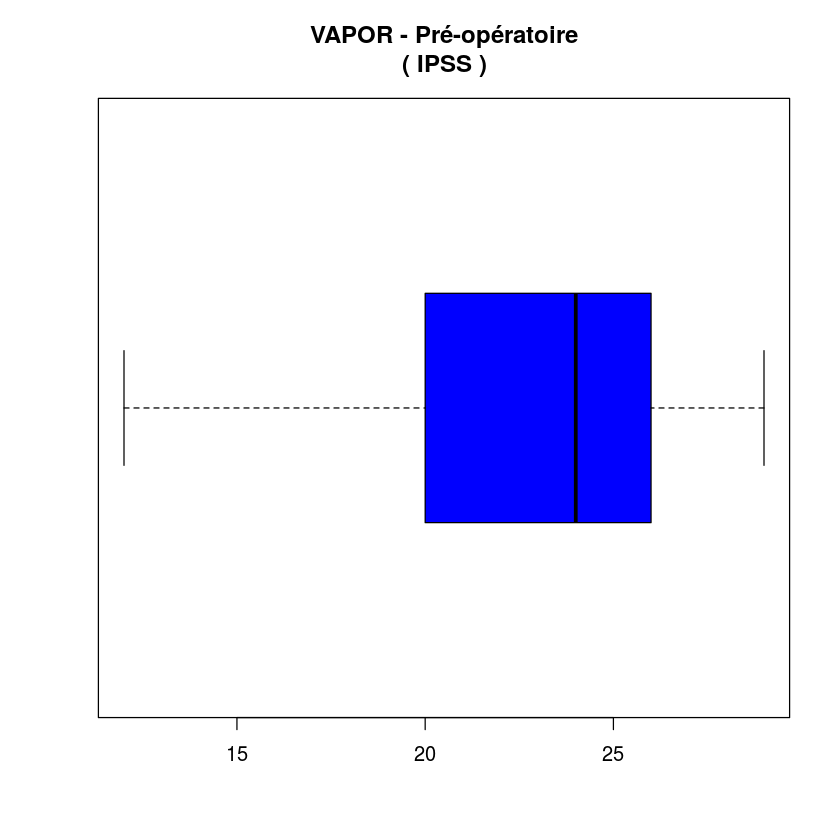

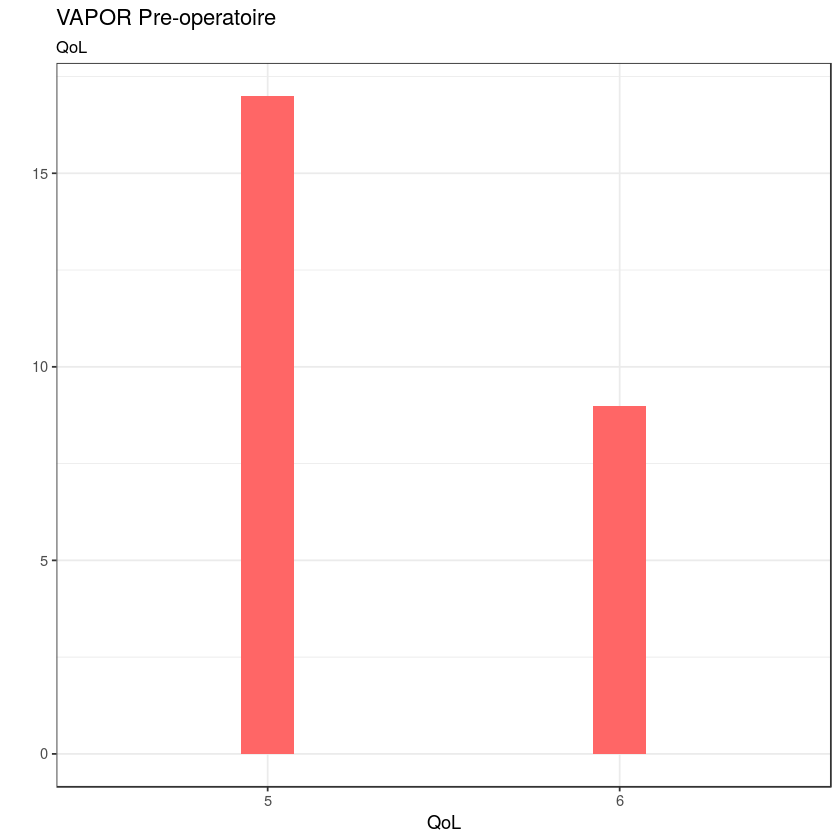

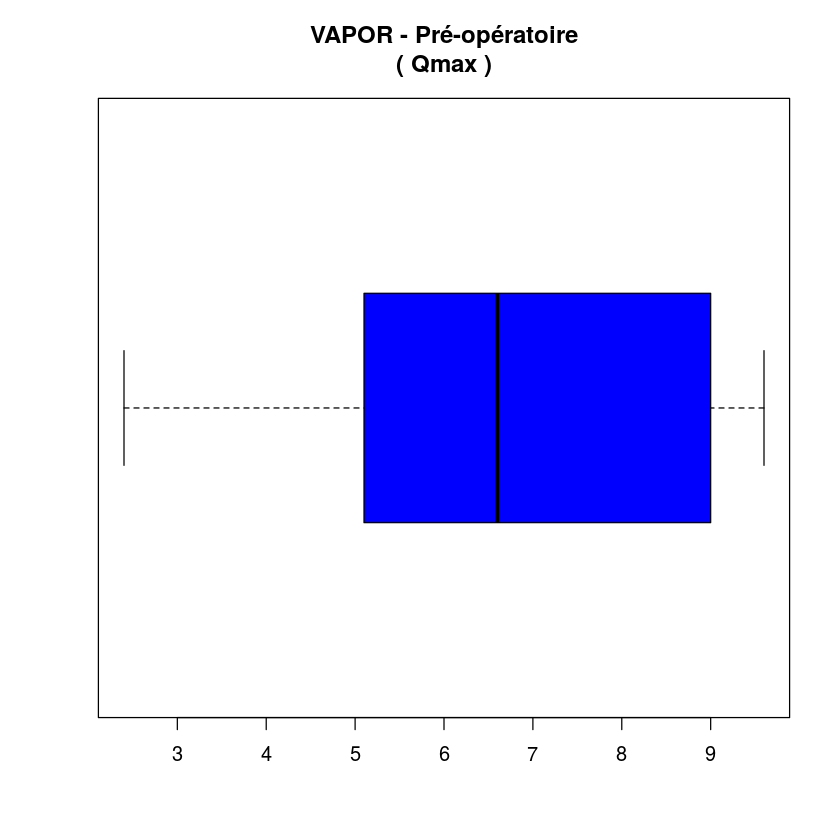

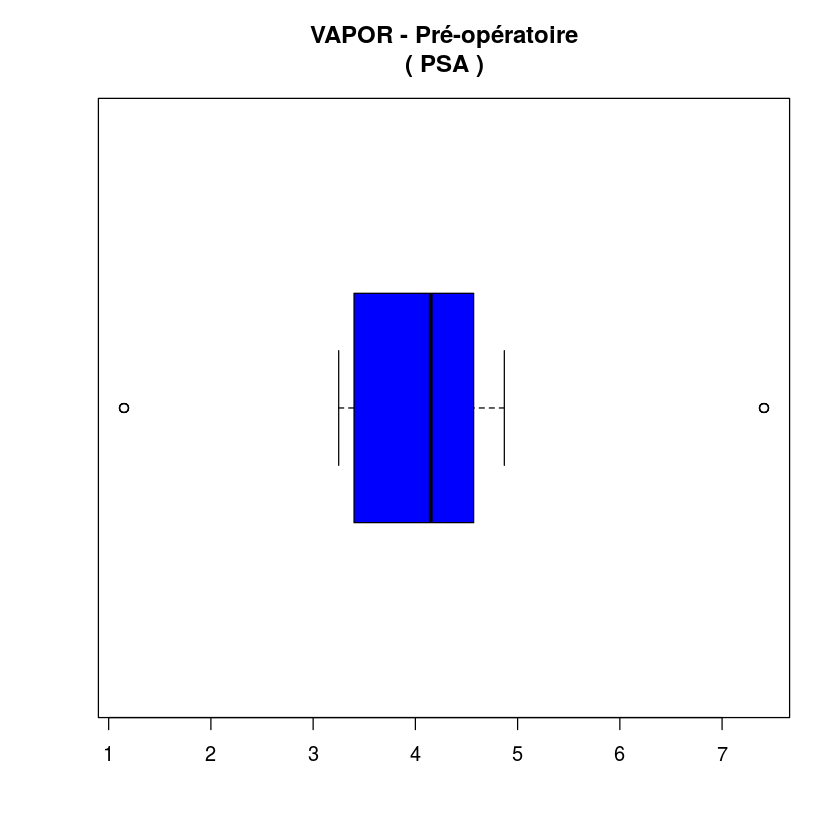

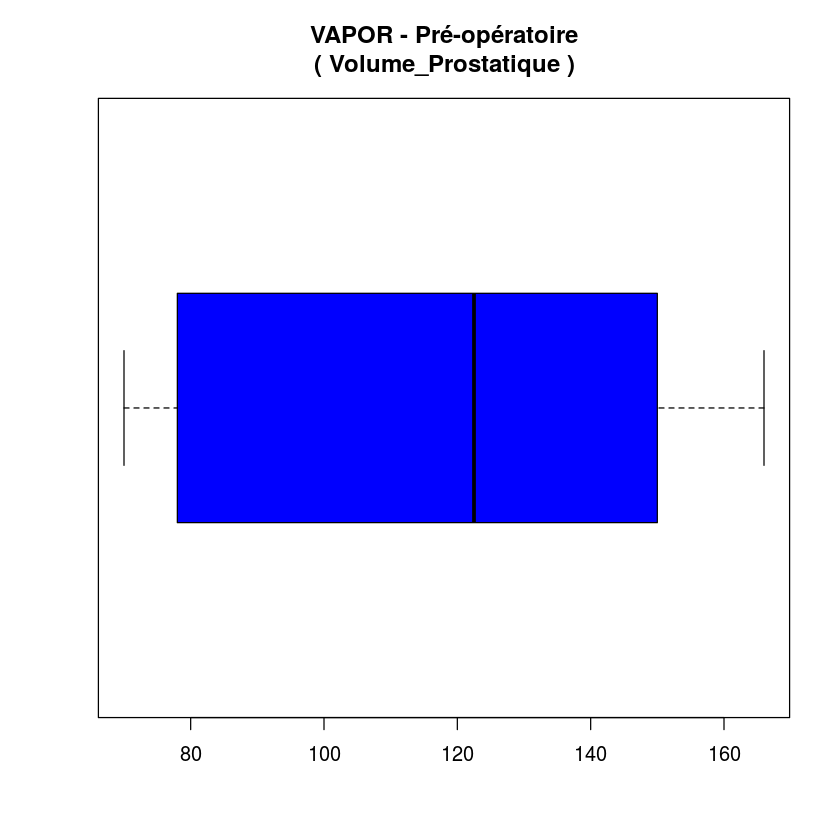

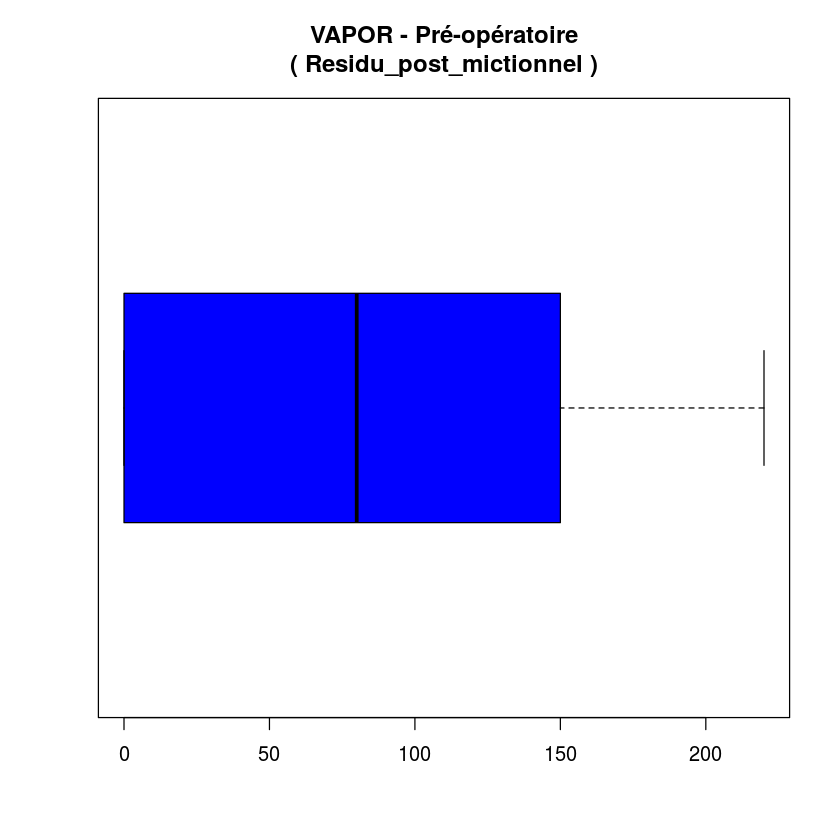

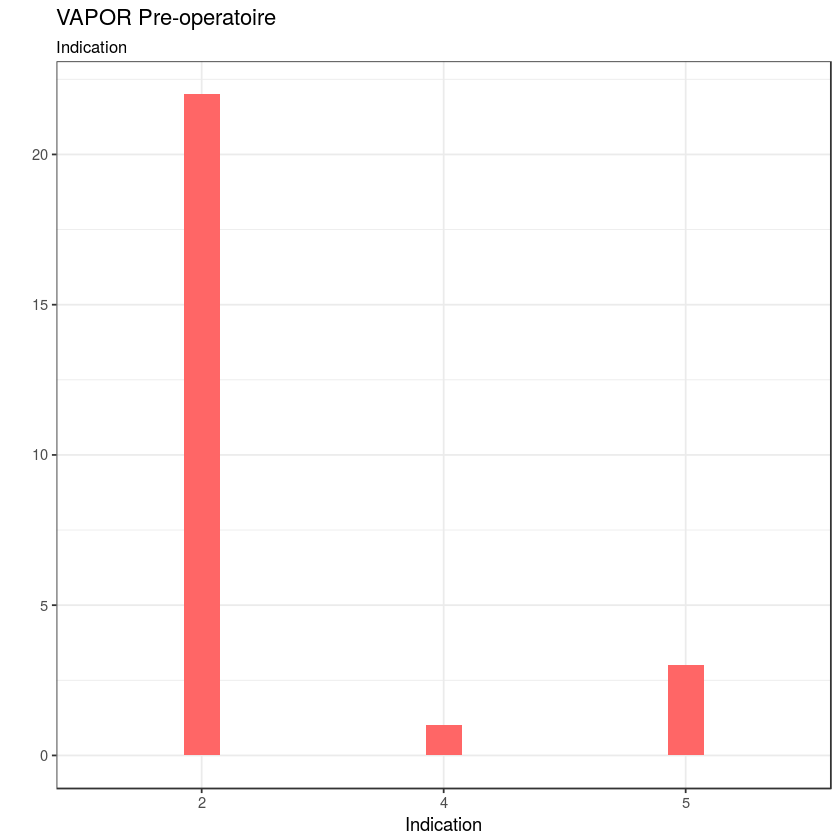

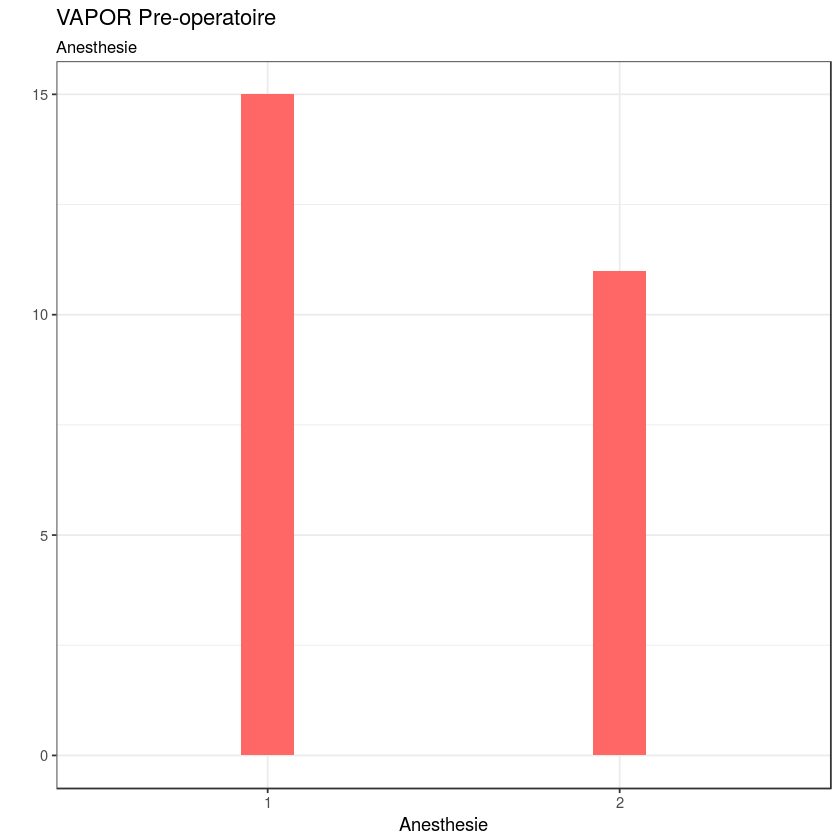

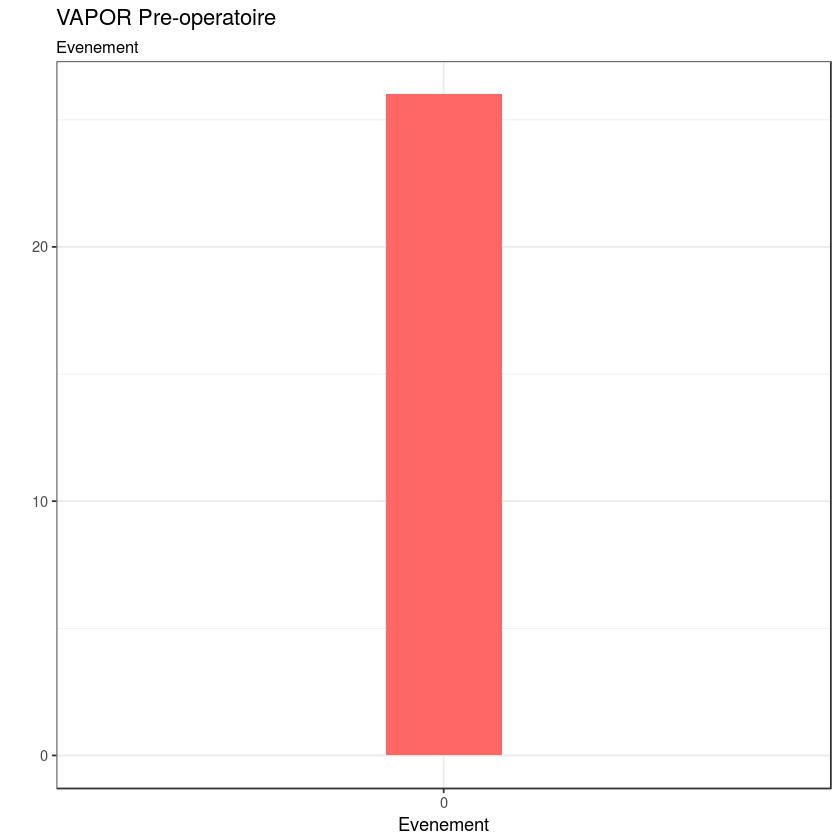

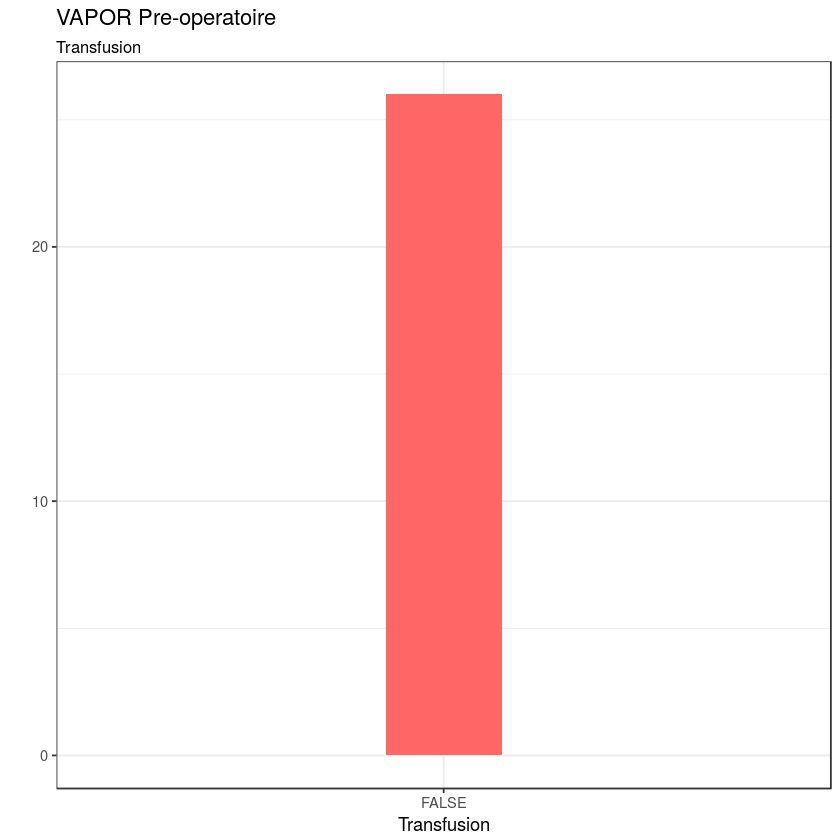

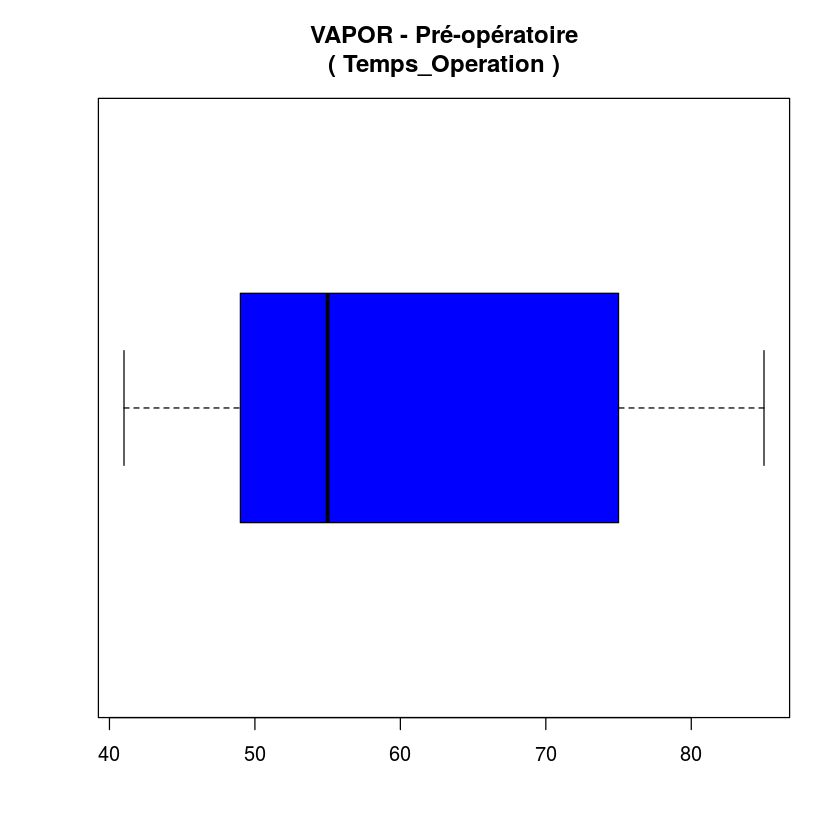

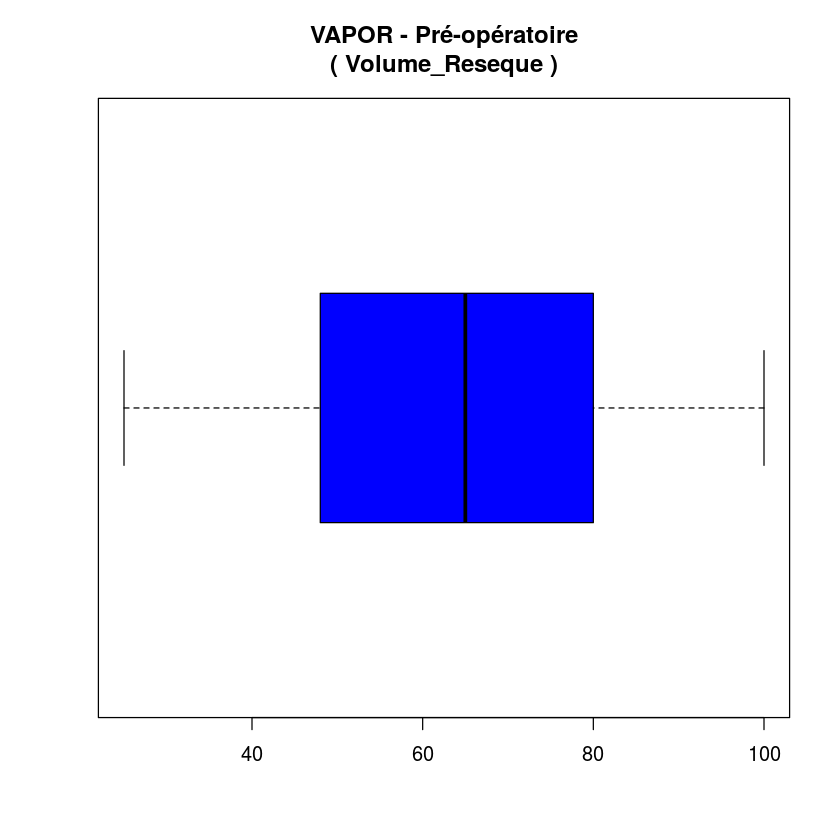

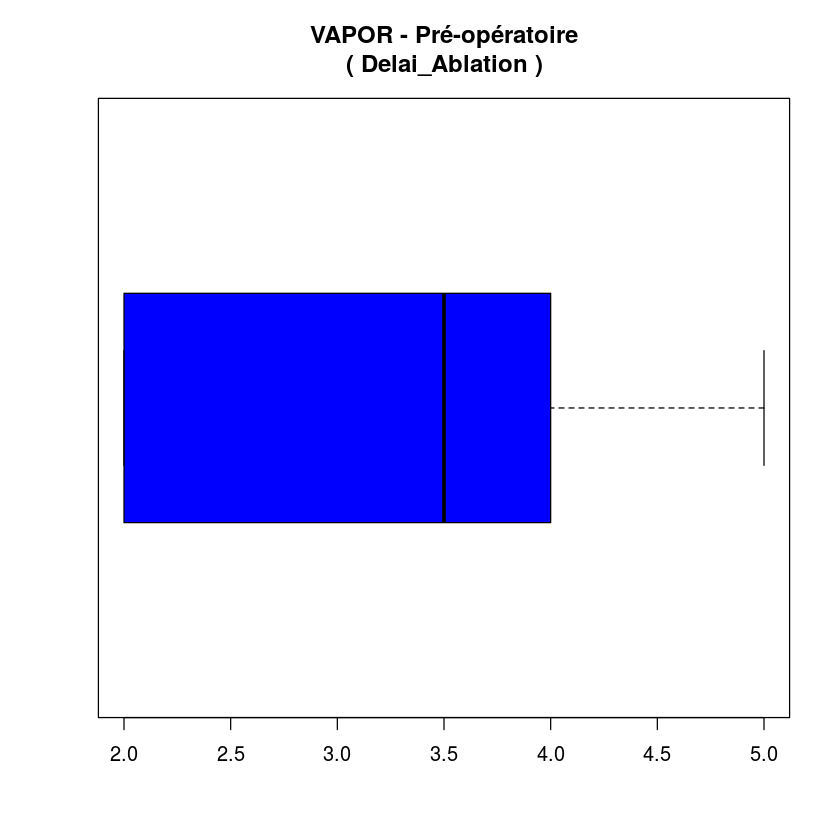

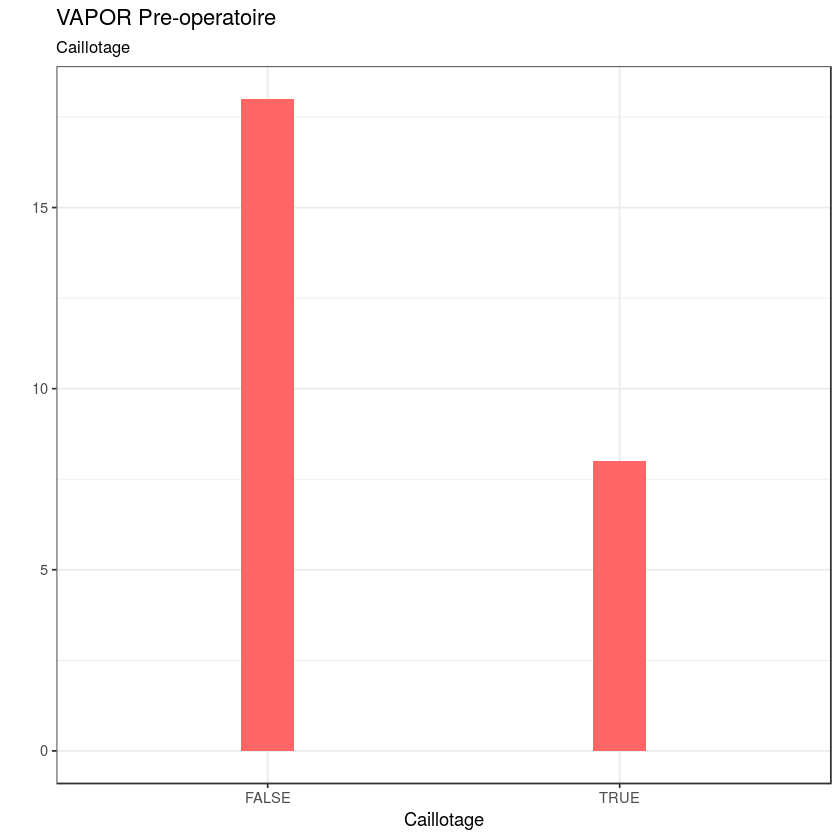

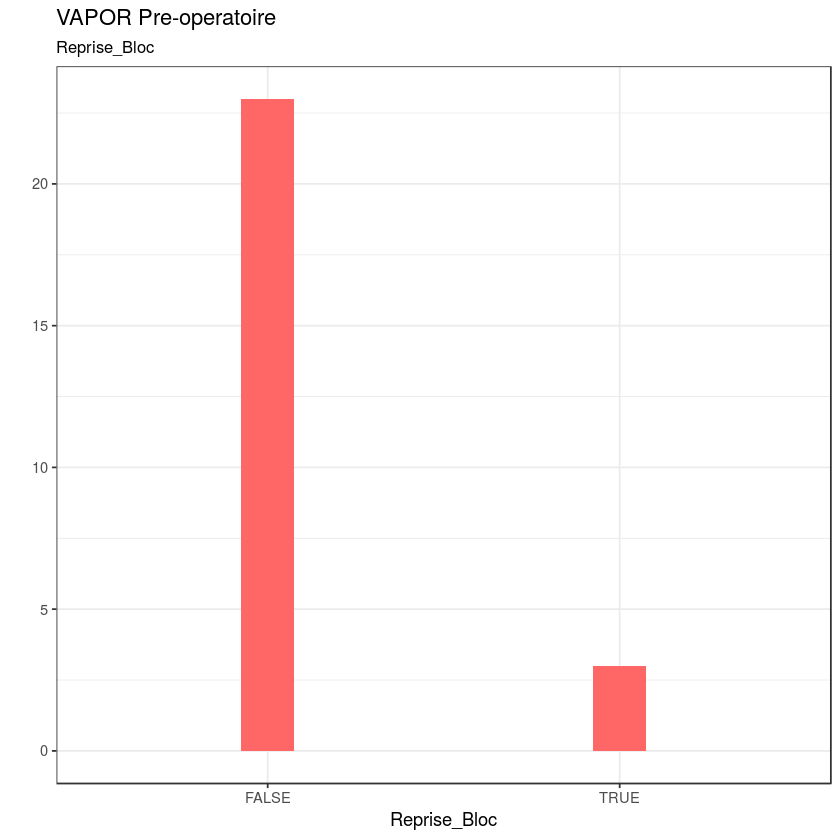

In [8]:
# Barplots des variables catégoriques
fill <- c("#d3d3d3", "#a8a8a8", "#7e7e7e", "#545454", "#2a2a2a")

for (i in 1:ncol(vapor_pre)) {
    # Boxplots des variables numériques
    if (is.numeric(vapor_pre[,i]))
        boxplot(vapor_pre[,i],
            names=c("VAPOR"),horizontal=TRUE,main=paste("VAPOR - Pré-opératoire\n(", colnames(vapor_pre)[i],")"), col=c("blue","red","#009900"))
    else {
        adenome_barplot(vapor_pre,i,"VAPOR Pre-operatoire")
    }
}

### 1.1.2 Corrélations Heatmap

Après avoir supprimé tout les individus porteurs de sonde et les variables qui n'apportent pas d'intêret à notre jeu de données on choisit de créer une matrice de corrélation.

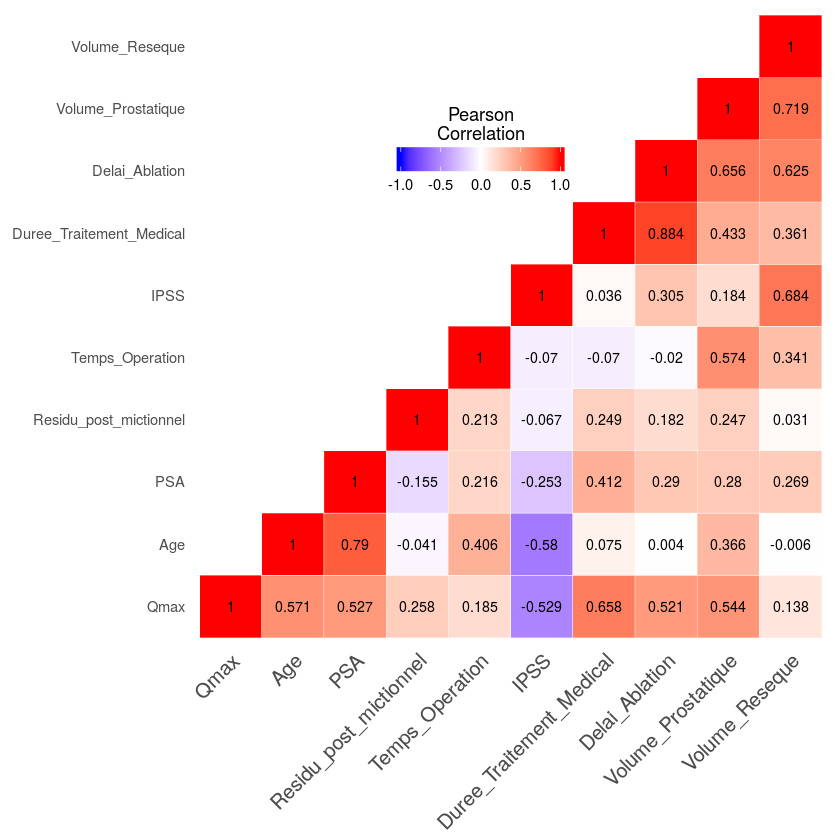

In [9]:
mat_cor_vapor_num_pre = cor(vapor_num_pre, method = c("pearson"))
adenome_heatmap(mat_cor_vapor_num_pre)

Nous notons une corrélation entre le "Volume Résequé" et le "Volume prostatique" ainsi qu'une corrélation négative entre "QMax"" et "IPSS". Plus la miction est bonne, plus la gêne est faible.
Dans une moindre mesure, nous notons une corrélation entre "Volume prostatique" et les variables suivantes :
- Temps Opération
- Délai Ablation

Nous notons enfin une corrélation entre "Durée Traitement Médical" et "Délai Ablation".

Ces corrélations peuvent être confirmées par les Scatterplots ci-dessous :

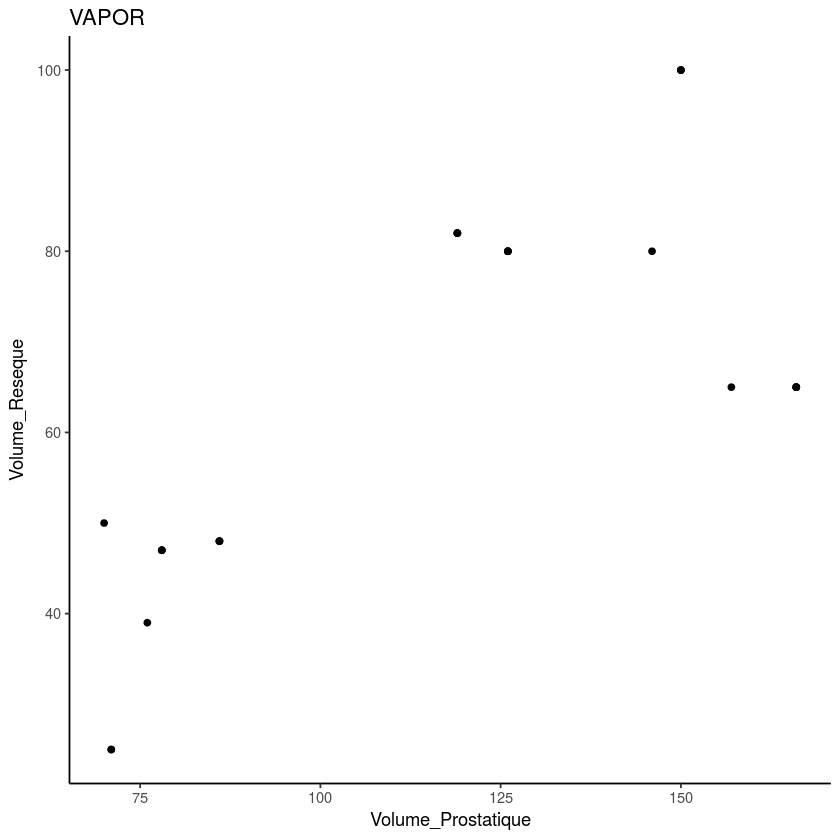

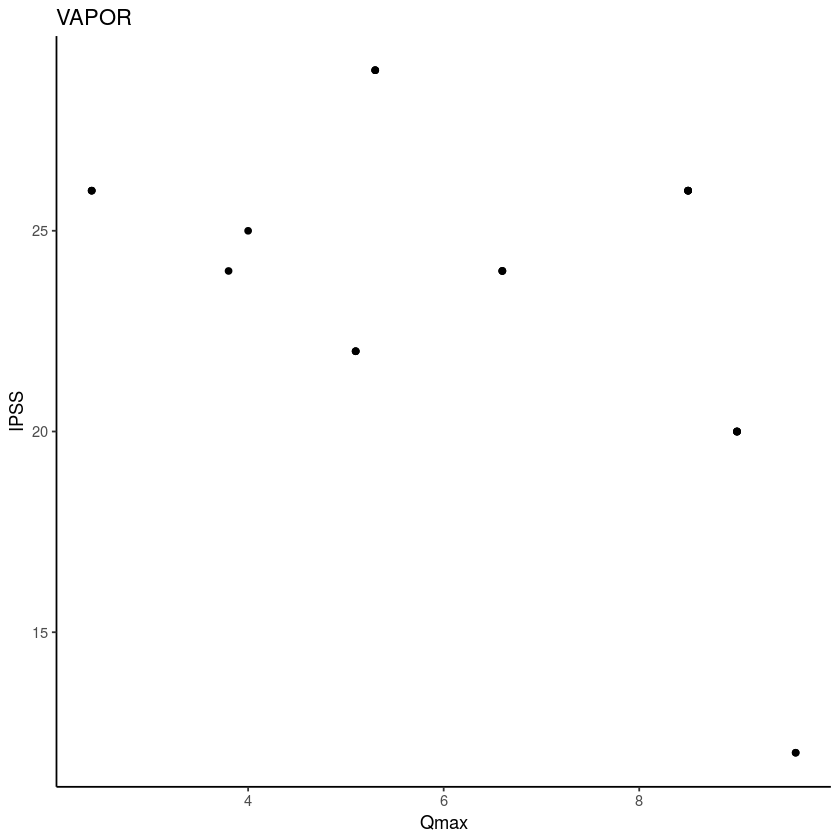

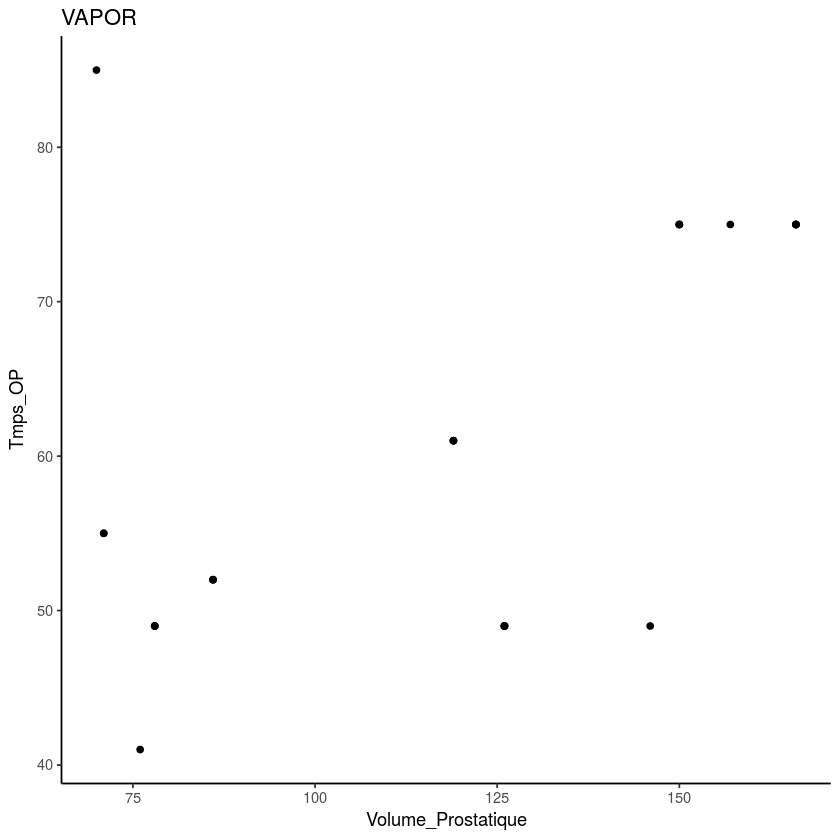

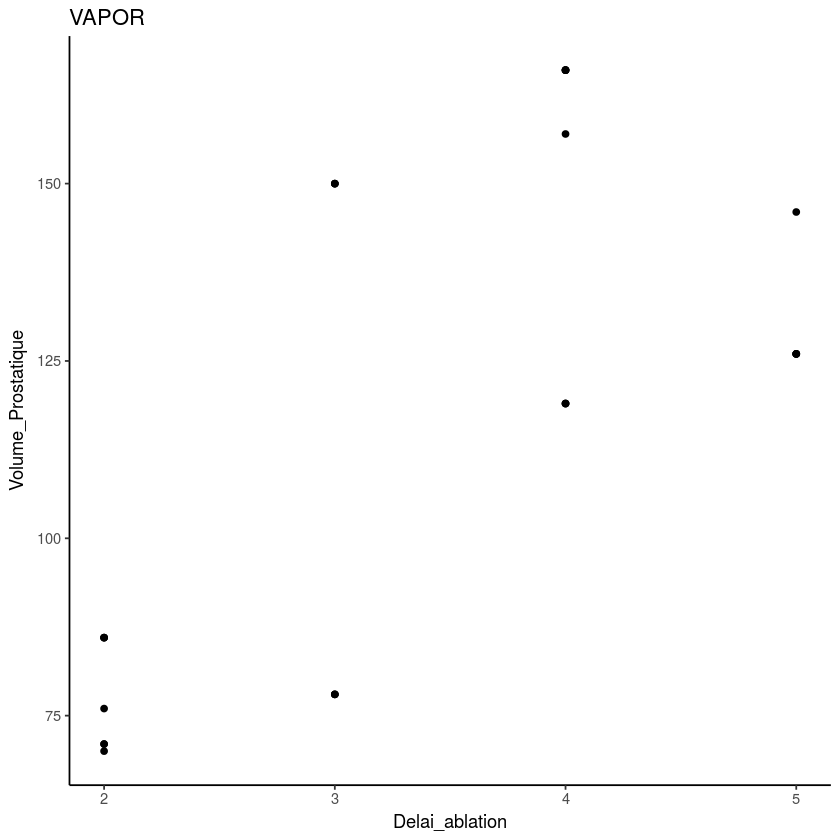

In [10]:
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Volume_Reseque,"Volume_Prostatique","Volume_Reseque")
adenome_scatterplot(vapor_pre,vapor_pre$Qmax,vapor_pre$IPSS,"Qmax","IPSS")
adenome_scatterplot(vapor_pre,vapor_pre$Volume_Prostatique,vapor_pre$Temps_Operation,"Volume_Prostatique","Tmps_OP")
adenome_scatterplot(vapor_pre,vapor_pre$Delai_Ablation,vapor_pre$Volume_Prostatique,"Delai_ablation","Volume_Prostatique")

### 1.1.3 Analyse en composantes principales

Nous procédons à une annalyse en composante principale afin de repérer les variables les plus reprèsentatives de nos individus.

In [11]:
pca <- stats::prcomp(x=subset(vapor_num_pre))
summary(pca)

Importance of components:
                           PC1     PC2     PC3      PC4     PC5     PC6     PC7
Standard deviation     82.3762 45.3519 30.8705 14.13017 8.72110 4.53780 1.79281
Proportion of Variance  0.6722  0.2037  0.0944  0.01978 0.00753 0.00204 0.00032
Cumulative Proportion   0.6722  0.8759  0.9703  0.99008 0.99761 0.99965 0.99997
                           PC8     PC9   PC10
Standard deviation     0.45901 0.23404 0.1108
Proportion of Variance 0.00002 0.00001 0.0000
Cumulative Proportion  0.99999 1.00000 1.0000

In [12]:
sum(100 * (pca$sdev^2)[1:3] / sum(pca$sdev^2))

[1] 97.03031

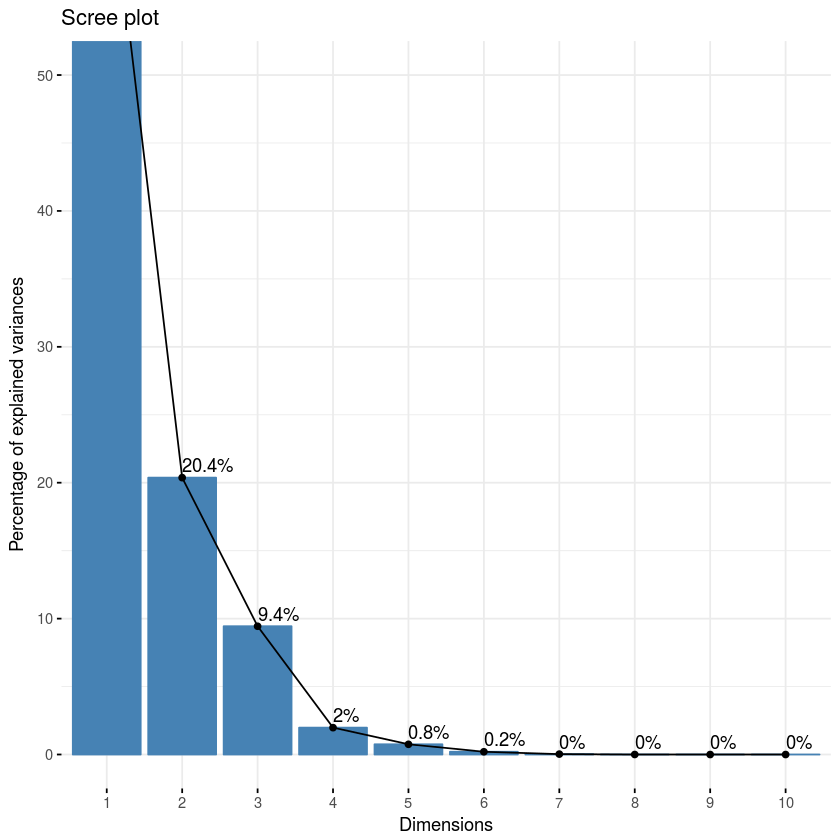

In [13]:
library(factoextra)
fviz_eig(pca, addlabels = TRUE, ylim = c(0, 50))

Ainsi  d'après le graphe ci-dessus et d'aprés la valeur de la proportion cumulative on peut déduire que les troiss premières composantes sont les plus représentatives. En effet ces composantes à elles seules contiennent 97.03%.

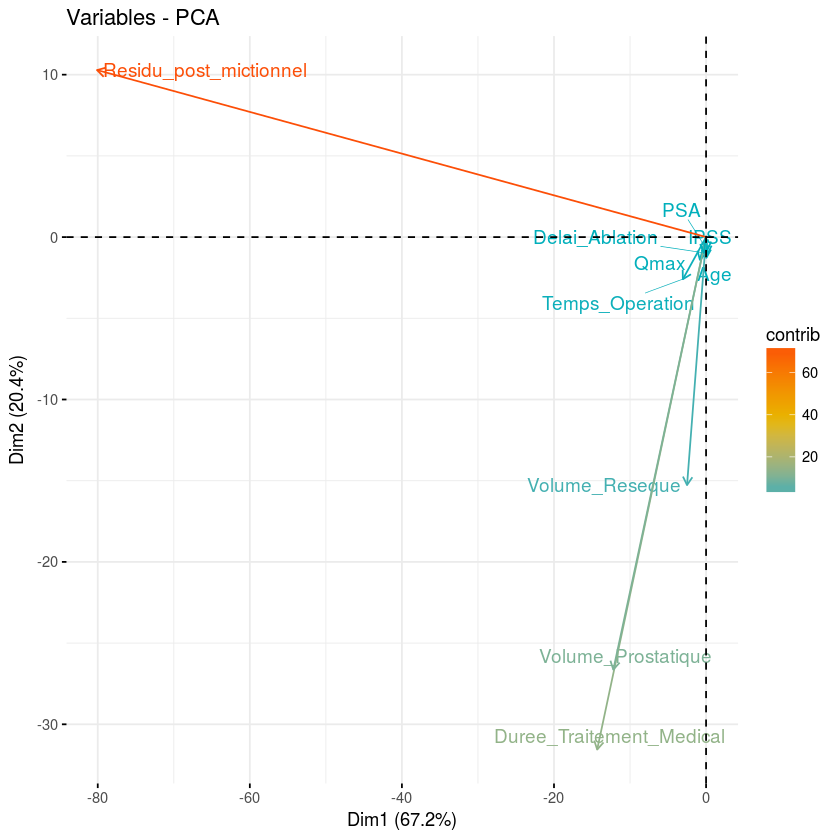

In [14]:
library("factoextra")
fviz_pca_var(pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE # Évite le chevauchement de texte
             )

En observant le graphe ci-dessus on peut déduire que les variables qui contribuent le plus dans la PC1 et la PC2  sont les variables: 'Résidu post mictionnel', 'Durée de traitement médical', 'Volume prostatique'  et 'Volume réséqué'.

# 1.2 Post-opératoire

### 1.2.1 Distributions

Afin de bien identifier qu'il existe des profils post opératoire différents on choisit 3 individus au hasard parmi le jeu de données post opératoires et en essaye de tracer l'évolution des trois variables suivantes : 'IPSS', 'QoL' et 'Qmax' en fonction du temps.

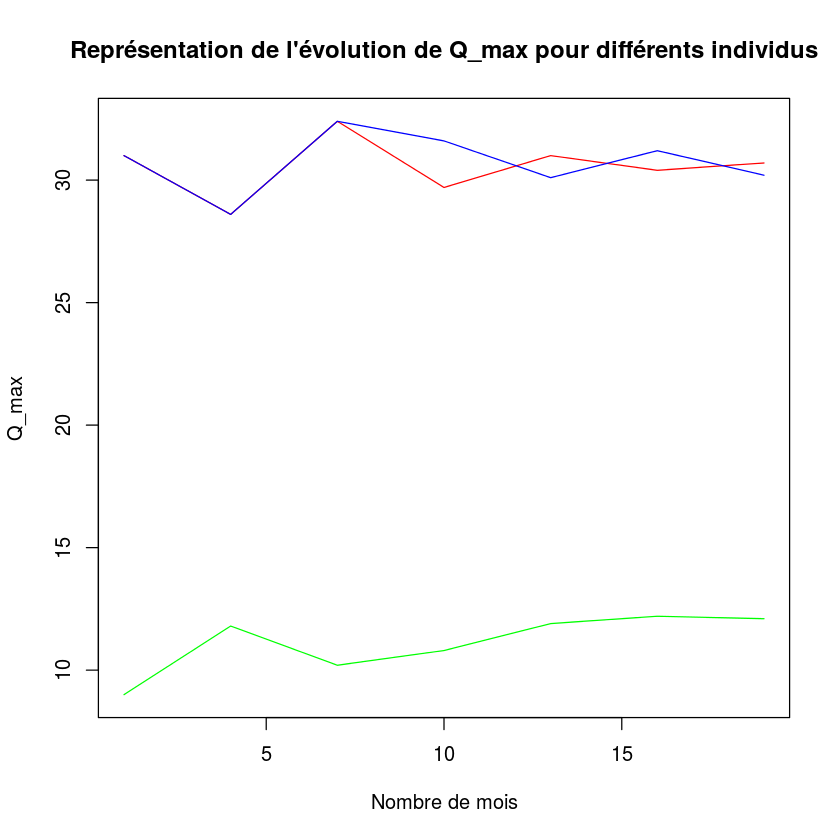

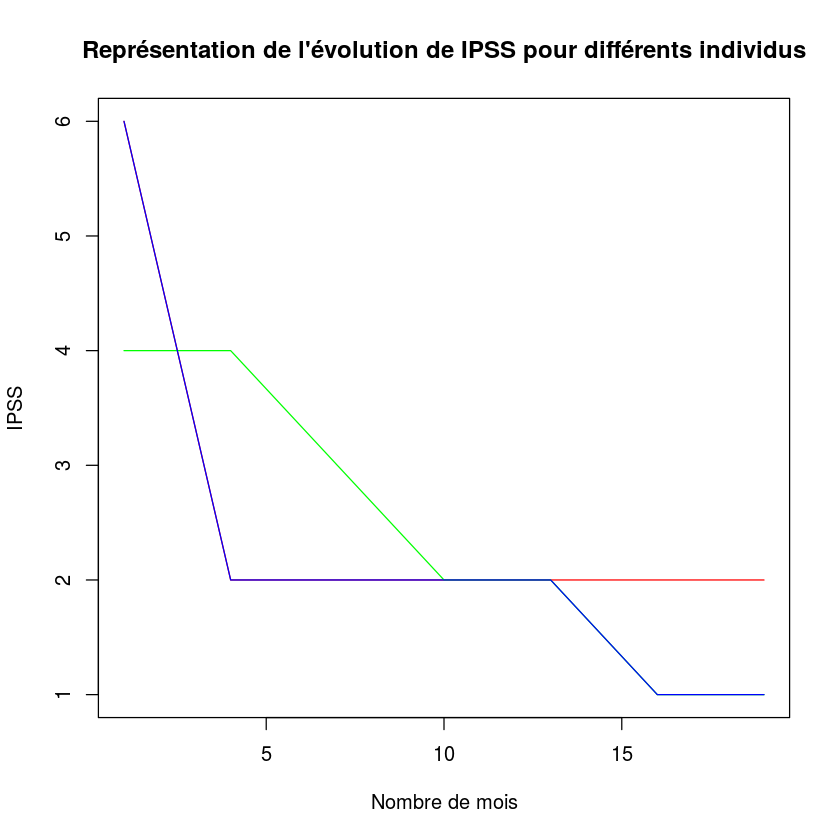

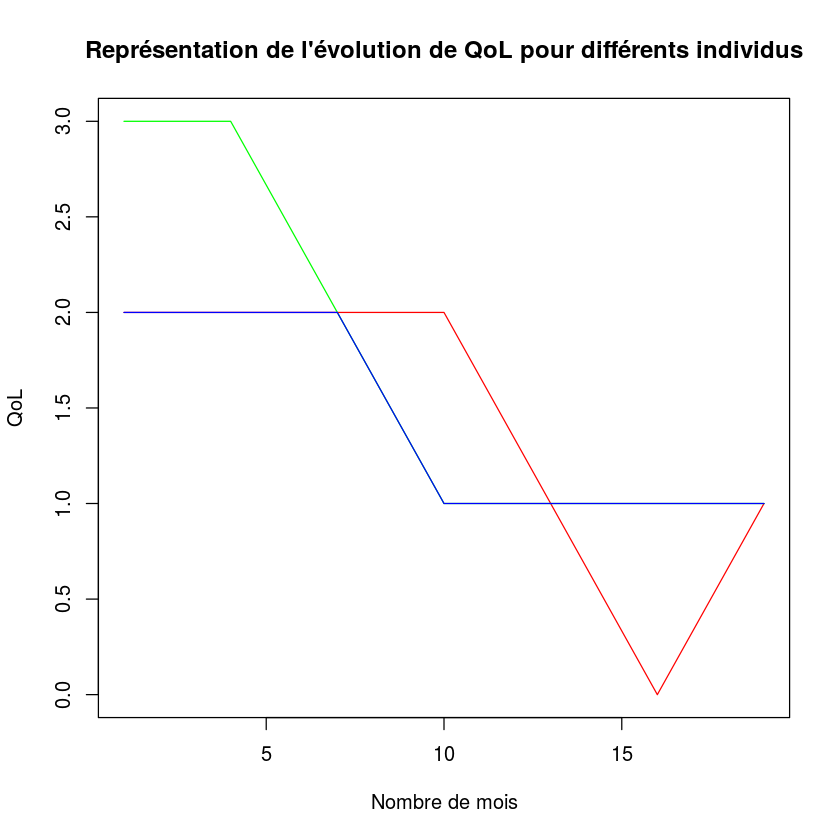

In [15]:
#On choisit trois individus au hazard
require(graphics)
individu= sample(1:nrow(vapor_num_post), 3)
i1=individu[1]
i2=individu[2]
i3=individu[3]
#On crée des séries temporels pour nos variable Q_max ,IPSS et QoL
vapor_num_post_qmax=t(subset(vapor_num_post,select=c(X1M_Qmax,X3M_Qmax,X6M_Qmax,X9M_Qmax,X12M_Qmax,X15M_Qmax,X18M_Qmax)))
vapor_num_post_ipss=t(subset(vapor_num_post,select=c(X1M_IPSS,X3M_IPSS,X6M_IPSS,X9M_IPSS,X12M_IPSS,X15M_IPSS,X18M_IPSS)))
vapor_cat_post_QoL=t(vapor_cat_post)
vapor_num_post_series_qmax=ts(vapor_num_post_qmax, start=1,deltat=3)
vapor_num_post_series_ipss=ts(vapor_num_post_ipss, start=1,deltat=3)
vapor_cat_post_series_QoL=ts(vapor_cat_post_QoL, start=1,deltat=3)

#On plot l'évolution de Q_max pour les 3 individus tirés au sort
Q_max_Individu1=vapor_num_post_series_qmax[,i1]
Q_max_Individu2=vapor_num_post_series_qmax[,i2]
Q_max_Individu3=vapor_num_post_series_qmax[,i3]
Q_max=cbind(Q_max_Individu1,Q_max_Individu2,Q_max_Individu3)
ts.plot(Q_max,gpars= list(col=rainbow(3)),xlab="Nombre de mois",ylab= "Q_max",main="Représentation de l'évolution de Q_max pour différents individus")

#On plot l'évolution de IPSS pour les 3 individus tirés au sort
Ipss_Individu1=vapor_num_post_series_ipss[,i1]
Ipss_Individu2=vapor_num_post_series_ipss[,i2]
Ipss_Individu3=vapor_num_post_series_ipss[,i3]
Ipss=cbind(Ipss_Individu1,Ipss_Individu2,Ipss_Individu3)
ts.plot(Ipss,gpars= list(col=rainbow(3)),ylab= "IPSS",xlab="Nombre de mois",main="Représentation de l'évolution de IPSS pour différents individus")


#On plot l'évolution de Qol pour les 3 individus tirés au sort
QoL_Individu1=vapor_cat_post_series_QoL[,i1]
QoL_Individu2=vapor_cat_post_series_QoL[,i2]
QoL_Individu3=vapor_cat_post_series_QoL[,i3]
QoL=cbind(QoL_Individu1,QoL_Individu2,QoL_Individu3)
ts.plot(QoL,gpars= list(col=rainbow(3)),xlab="Nombre de mois",ylab= "QoL",main="Représentation de l'évolution de QoL pour différents individus")



Ainsi les différents tracés ci-dessus sont des tracés des séries temporelles des variables pour différents individus.Ces graphes montrent bien qu'il existe un certains nombre de profils différents ; ici 3 profils. On peut même dire qu'on aura un nombre de clusters supérieur ou égal à 3 .

Ensuite on trace des boxplot montrant l'évolution de ces trois variables à travers les mois. 

a. Qmax

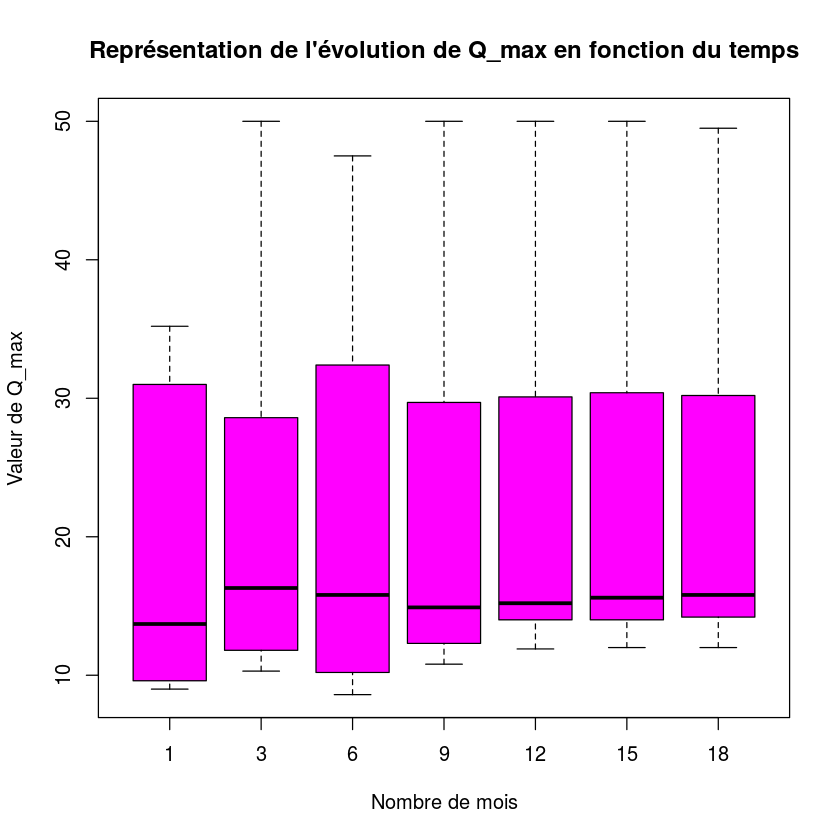

In [16]:
#On trace l'évolution de QMax en fonction du temps
Boxplot=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=vapor_num_post$X1M_Qmax[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
Qmax=subset(vapor_num_post,select=c(X3M_Qmax,X6M_Qmax,X9M_Qmax,X12M_Qmax,X15M_Qmax,X18M_Qmax))
for (i in 1:ncol(Qmax)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=Qmax[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="Représentation de l'évolution de Q_max en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de Q_max")

Pour Q_max on remarque qu'après l'opèration le patient voit généralement son Q_max augmenté au fur et à mesure du temps pour stagner par la suite. 

b. IPSS

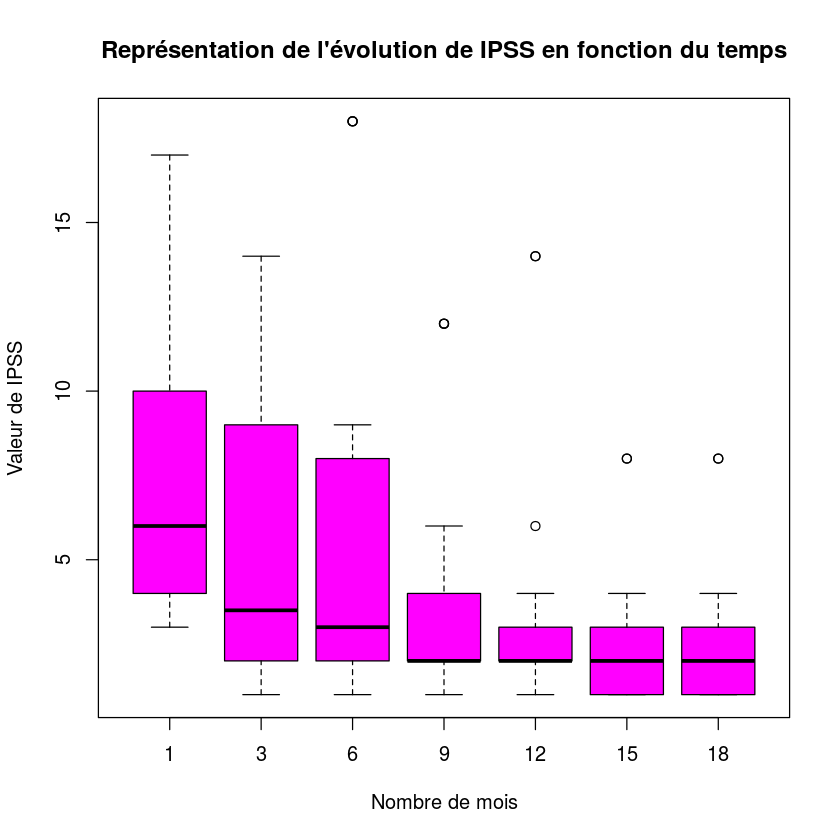

In [17]:
#On trace l'évolution d'IPSS en fonction du temps
Boxplot=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=vapor_num_post$X1M_IPSS[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
ipss=subset(vapor_num_post,select=c(X3M_IPSS,X6M_IPSS,X9M_IPSS,X12M_IPSS,X15M_IPSS,X18M_IPSS))
for (i in 1:ncol(ipss)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=ipss[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="Représentation de l'évolution de IPSS en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de IPSS")


D'aprés les boxplot ci-dessus on remarque que la valeur d'IPSS diminue progressivement après l'opération puis stagne au niveau du 15ième et 18ième mois. En effet cette diminution est logique car après l'opération les symptômes sont censés disparaitre et le patient se sent de mieux en mieux.

c. QoL

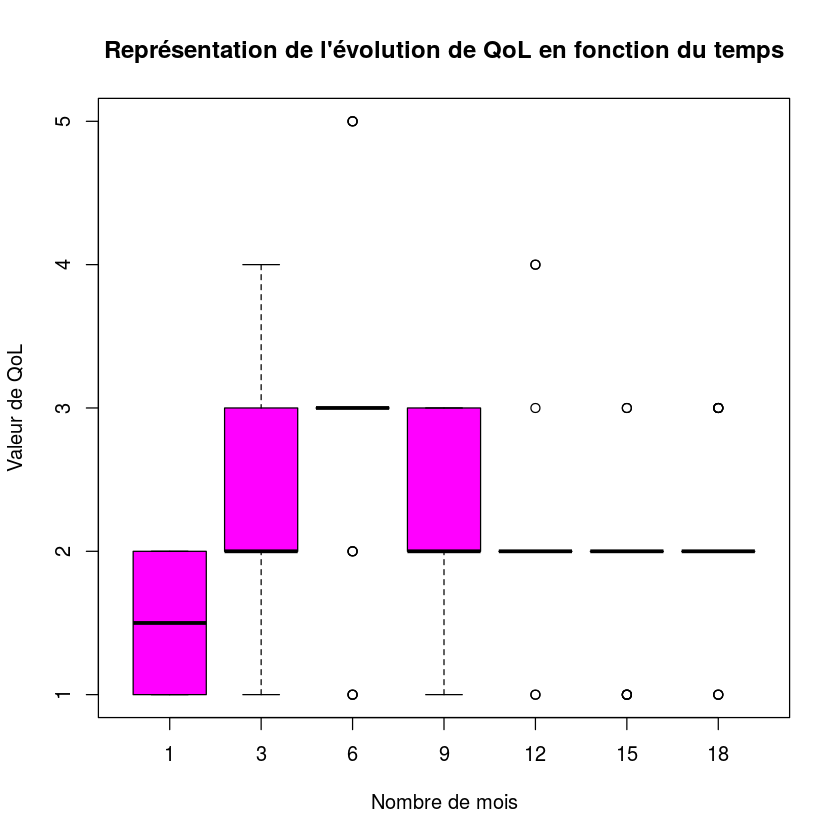

In [18]:
#On trace l'évolution de QoL en fonction du temps
Boxplot=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
for (i in 1:nrow(Boxplot)){
    Boxplot[i,2]=vapor_cat_post$X1M_QoL[i]
    Boxplot[i,1]=1
}
Boxplot2=matrix(NA,nrow=nrow(vapor_num_post),ncol=2)
QoL=subset(vapor_cat_post,select=-c(X1M_QoL))
for (i in 1:ncol(QoL)){
for (k in 1:nrow(Boxplot2)){
    Boxplot2[k,2]=QoL[k,i]
    Boxplot2[k,1]=i*3
}
Boxplot=rbind(Boxplot,Boxplot2)
}
boxplot(Boxplot[,2]~Boxplot[,1], main="Représentation de l'évolution de QoL en fonction du temps", col=6 ,xlab="Nombre de mois", ylab="Valeur de QoL")


Contrairement à l'IPSS, la QoL (Quality of life) augmente progressivement puis se stabilise au bout du 9ième mois. Cette variable nous indique à quel point l'individu ressent l'amélioration après son opération. 

Le fait d'avoir l'IPSS et QoL qui évoluent inversement vient confirmer la corrélation négative trouvée dans l'analyse descriptive des données pré-opératoires. 

# 2 Clustering des données VAPOR 
## 2.1 Extraction des profils types des patients à partir des données pré-opératoires
### 2.1.1 PAM

Avant de procéder à PAM on peut exécuter une commande "CMDScale" permettant de représenter la dissimilarité entre les individus. Cette représentation peut nous donner un nombre approximatif des clusters pour notre jeu de données.

Warning message in daisy(vapor_pre, metric = c("gower")):
“setting 'logical' variables 2, 13, 17, 18 to type 'asymm'”

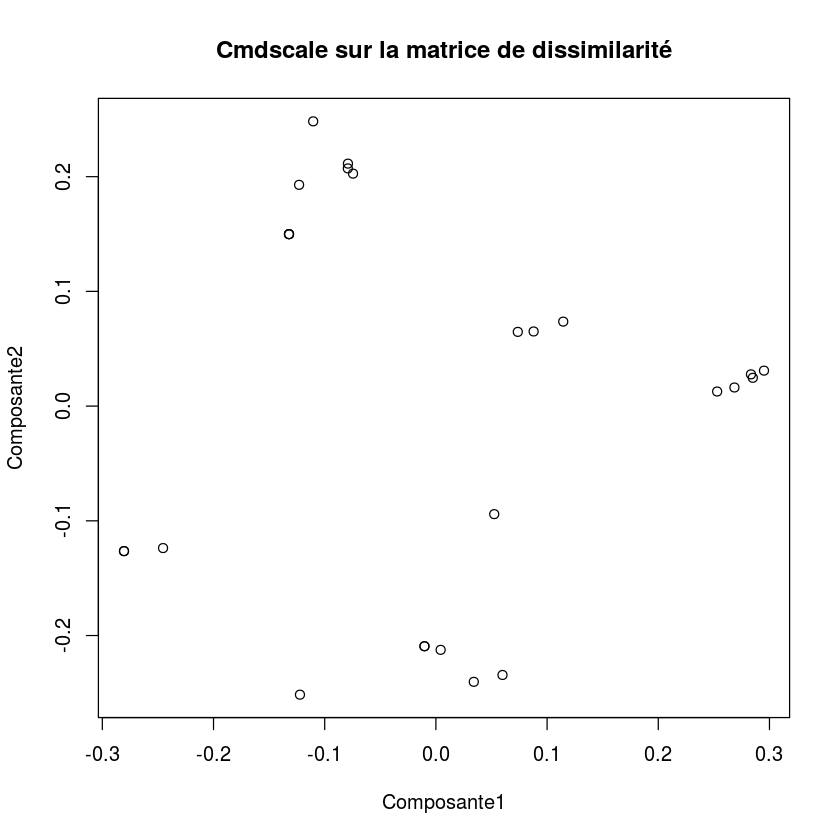

In [19]:
require(cluster)
library(fpc)
#On crée notre matrice de dissimilarité utilisant daisy car matrice hétérogène
disMatrix_pre=daisy(vapor_pre,metric = c("gower"))
cmd=cmdscale(disMatrix_pre,k=2)
plot(cmd[,1],cmd[,2],main="Cmdscale sur la matrice de dissimilarité",xlab="Composante1",ylab="Composante2")

A travers le graphe ci-dessus on peut bien voir qu'il existe problablement autour de 6 ou 7 clusters pour notre jeu de données. Pour s'en rassurer on va faire une étude PAM qui va nous valider cette intuition.

In [20]:
#On fait une boucle pour repèrer les 5 meilleurs valeurs de k qui maximise la valeur silhouette
respam<- numeric(20)
for (k in 2:20)
respam[[k]] <- pam(disMatrix_pre,k) $ silinfo $ avg.width
sortrespam=respam[which(respam>0.7)]
sortrespam=sort(sortrespam,decreasing=TRUE)
k.best=c()
for (i in 1:length(sortrespam)){
        k.best[i] <-which(respam[]==sortrespam[i])
}
#On regarde le min de k pour une valeur silhouette supérieur à 0.7
k.min<-min(k.best)
cat("Les 5 meilleurs nombre de clusters sont", k.best[1:5], ". Ayant une valeur silhouette de ",respam[k.best[1:5]],". Le nombre de cluster pour une valeur silhouette maximale est=" ,k.best[1]," . \n")
cat("Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est", k.min, " et ayant un valeur silhouette de ",respam[k.min],"\n")

Les 5 meilleurs nombre de clusters sont 9 8 7 11 6 . Ayant une valeur silhouette de  0.8127144 0.7950656 0.7544874 0.7517804 0.7395041 . Le nombre de cluster pour une valeur silhouette maximale est= 9  . 
Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est 6  et ayant un valeur silhouette de  0.7395041 



Ainsi d'après cette comparaison on peut très bien voir que le nombre optimal de clusters à choisir est de 6. En effet cette valeur parait assez correcte vu qu 'elle propose une valeur silhouette de 0.74 qui n'est pas trés loin de la valeur maximale qui est de 0.81 et qui propose des clusters d'une moyenne de 4 individus.

In [21]:
k.optimal_pre=k.min

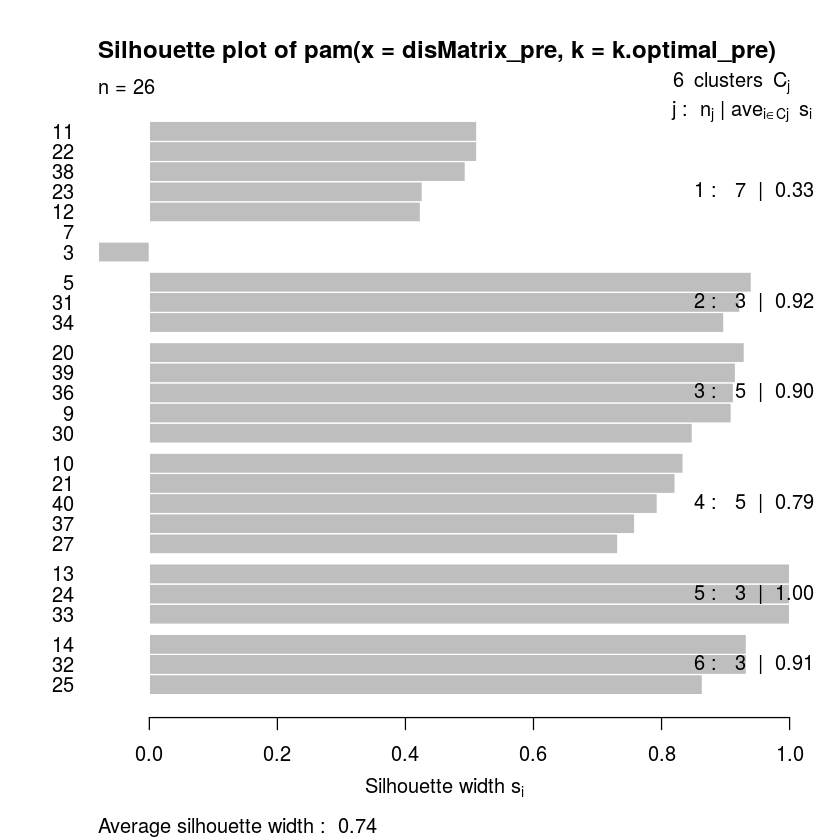

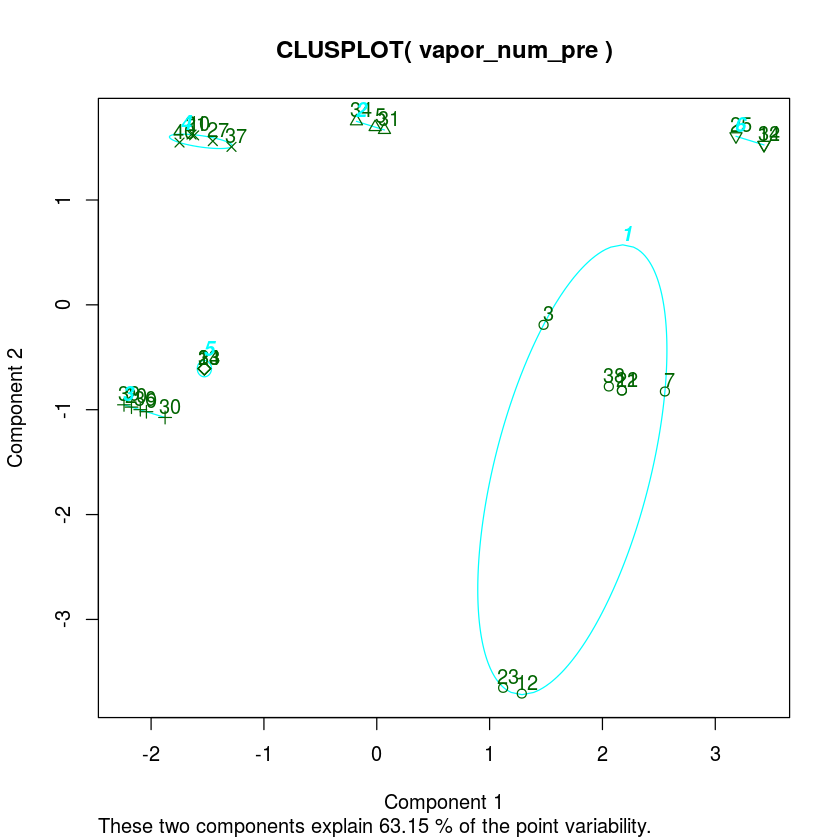

In [22]:
library(fpc)
respam_optimal_pre=pam(disMatrix_pre,k.optimal_pre)
plot(respam_optimal_pre)
vapor_pre_sans_res_num=subset(vapor_num_pre[which(vapor_num_pre$Residu_post_mictionnel != ""),])
clusplot(vapor_num_pre, respam_optimal_pre$clustering, labels=2, lines=0)

### 2.1.2 CAH

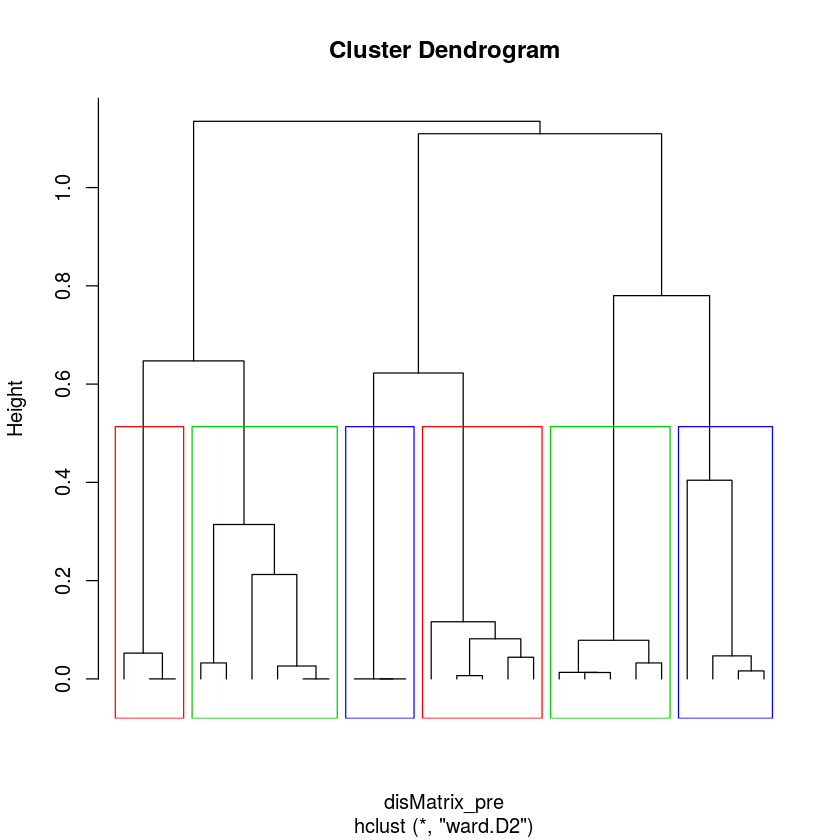

In [23]:
resuhc <- hclust(disMatrix_pre, method = "ward.D2")
# Visualization de resuhc
plot(resuhc, labels = FALSE, hang = -1)
# Ajout des rectangles autour des clusters
rect.hclust(resuhc, k =k.optimal_pre, border = 2:4) 

D'apès le dendrogramme on remarque que le choix d'un nombre de cluster égal 6 est judicieux. En effet on coupe la où la hauteur des branches est très grande. La hauteur des branche nous identifie la proximité entre les classes. Ainsi plus cette hauteur est grande plus les classes sont séparées. 
En conclusion, la cah vient valider le résultat qu'on retrouve avec Pam et confirmer le nombre de clusters qu'on a trouvés.

### 2.1.3 Caractérisation des patients médoids

In [24]:
#Indication des médoids
medoid_pre=c()
respam_optimal_pre=pam(disMatrix_pre,k=k.optimal_pre)
medoids_pre=respam_optimal_pre$medoids
for (i in 1:length(medoids_pre)){
   medoid_pre=rbind(medoid_pre,vapor_pre[medoids_pre[i],])
    }
medoid_pre

,Age,Comorbidite,Duree_Traitement_Medical,IPSS,QoL,Qmax,PSA,Volume_Prostatique,Residu_post_mictionnel,Indication,Anesthesie,Evenement,Transfusion,Temps_Operation,Volume_Reseque,Delai_Ablation,Caillotage,Reprise_Bloc
22,68,FALSE,11,22,5,5.1,3.25,86,80,2,2,0,FALSE,52,48,2,FALSE,FALSE
5,65,FALSE,12,29,6,5.3,3.40,150,50,5,1,0,FALSE,75,100,3,FALSE,FALSE
20,73,FALSE,72,20,6,9.0,4.57,166,180,2,2,0,FALSE,75,65,4,FALSE,FALSE
10,63,FALSE,120,26,5,8.5,4.15,126,200,2,1,0,FALSE,49,80,5,TRUE,FALSE
33,74,TRUE,72,24,5,6.6,7.41,119,0,2,1,0,FALSE,61,82,4,TRUE,TRUE
32,58,TRUE,21,26,5,2.4,1.15,78,0,2,1,0,FALSE,49,47,3,FALSE,FALSE


Ainsi  grace à létude ci dessus et à l'ACP faite précédemment on remarque que les patients medoids se caractérisent particulièrement par leur âge, la durée de traitement médical, le volume prostatique, le résidu post mictionnel et le volume réséqué.
Cependant on peut caractériser chacune des classes trouvées : 

-> Classes d'individus  moyennement agés

-La première classe représente des individus moyennement agés qui ont à peu prés 63 ans avec un volume prostatique moyen, une durée de traitement médical assez grande, un résidu post mictionnel très grand et un volume réséqué moyen.

-La seconde classe représente des individus également moyennement agés qui ont à peu prés 65 ans avec un volume prostatique trés grand, une durée de traitement médical trés faible, un résidu post mictionnel moyen et un volume réséqué trés grand.     

-La trosième classe représente des individus un peu plus agés que les deux première classes qui ont autour de 68 ans avec un volume prostatique moyen, une durée de traitement médical trés faible, un résidu post mictionnel moyen et un volume réséqué petit.

->Classes d'individus agés

-La quatrième classe représente des individus agés ayant autour de 73 ans avec un volume prostatique trés grand, une durée de traitement moyenne, un résidu post mictionnel trés grand et un volume réséqué moyen voir petit.

-La cinquième classe repésente des individus ayant approximativement le même age que ceux de la classes précédente avec un volume prostatique moyen, une durée de traitement moyenne et un résidu post mictionnel à zéro et un volume réséqué  moyen.

->Classe d'individus les plus jeunes

-La dernière classe représente les individus les plus jeunes ayant autour de 58 ans avec un volume prostatique assez petit, une durée de traitement faible, un résidu post mictionnel à zéro et un volume réséqué petit.

### 2.1.4 Visualisation des distributions du Q_max à 12 mois pour les différentes classes

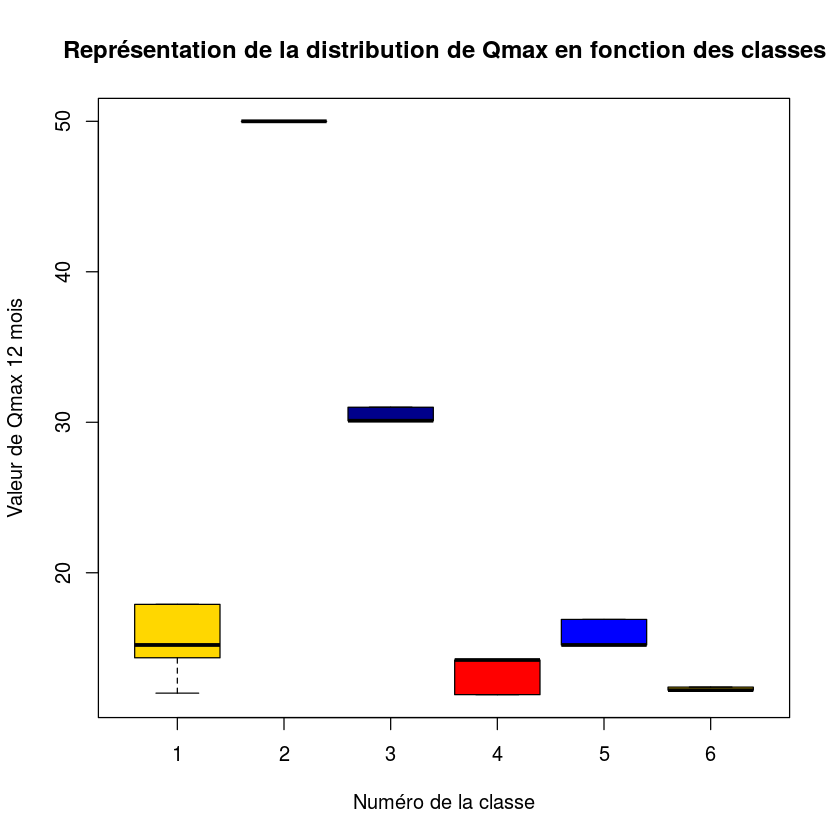

In [25]:
clusters=respam_optimal_pre$clustering
Boxplot2=matrix(NA,ncol=2,nrow=10)
for(i in 1:6){
    clust=vapor_num_post$X12M_Qmax[which(clusters==i)]
    for (j in 1:length(clust)){
       Boxplot2[j,2]=clust[j]
        Boxplot2[j,1]=i
}
Boxplot2=rbind(Boxplot2,Boxplot2)
}

boxplot(Boxplot2[,2]~Boxplot2[,1], main="Représentation de la distribution de Qmax en fonction des classes", col=(c("gold","darkgreen","darkblue","red","blue")), ,xlab="Numéro de la classe", ylab="Valeur de Qmax 12 mois")

On remarque que pour la 1ère, la 3ième et la 5ième classe, les valeurs de Q_max ne sont pas très homogènes entre les individus comme pour la 2ième, 4ième et 6ième classes où les valeurs de Q_max sont toutes trés proches les unes des autres. 

On peut également visualiser chacun de ses Q_max de chaque classe indépendamment des autres pour avoir une vision plus claire sur les différentes valeurs.

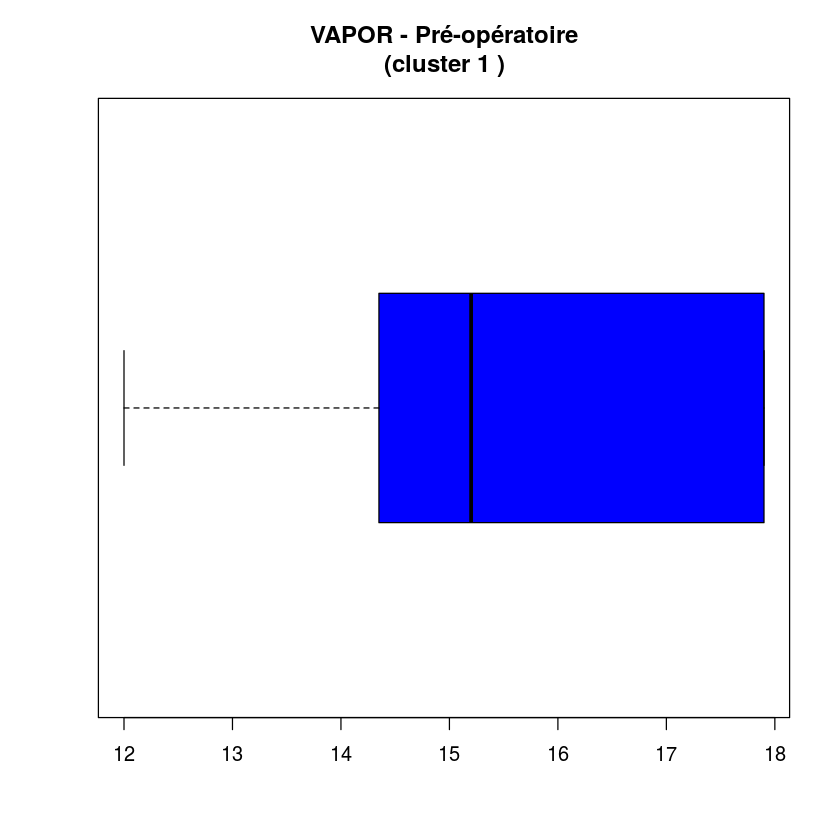

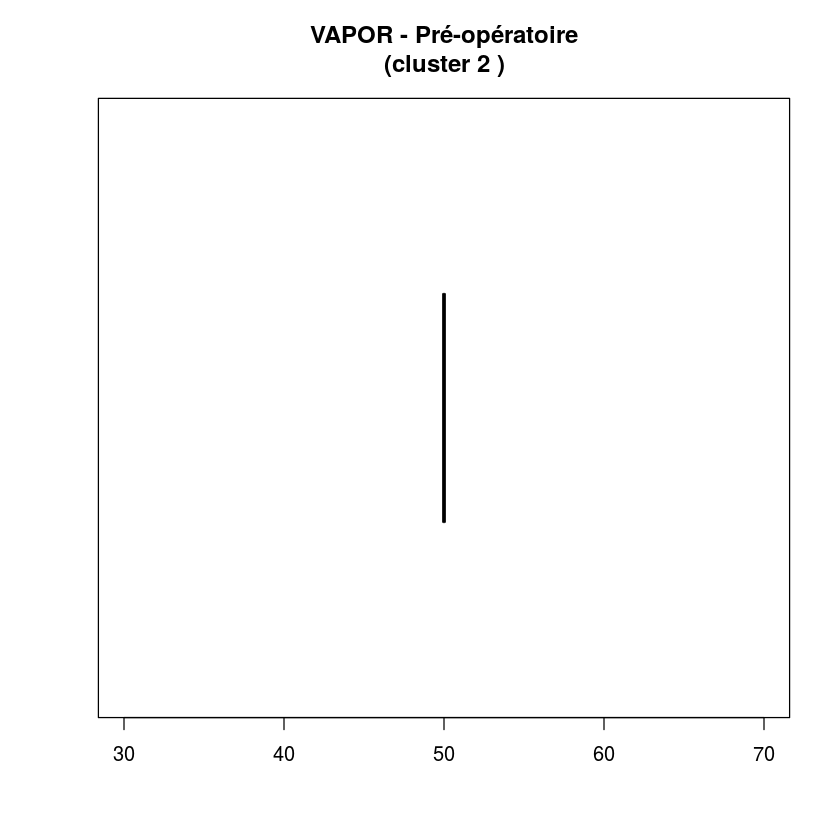

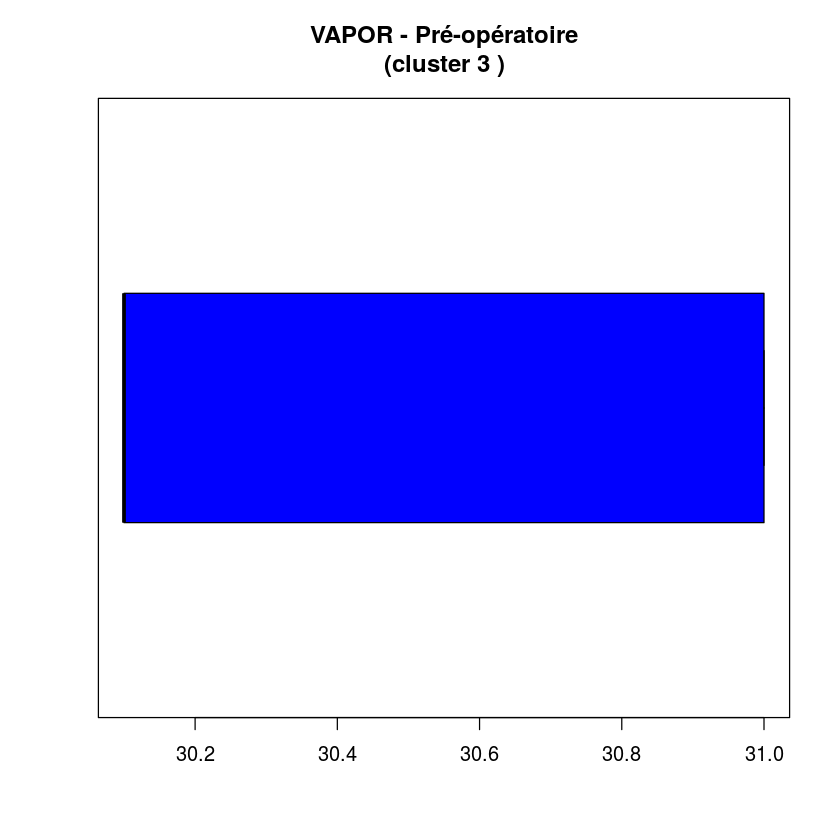

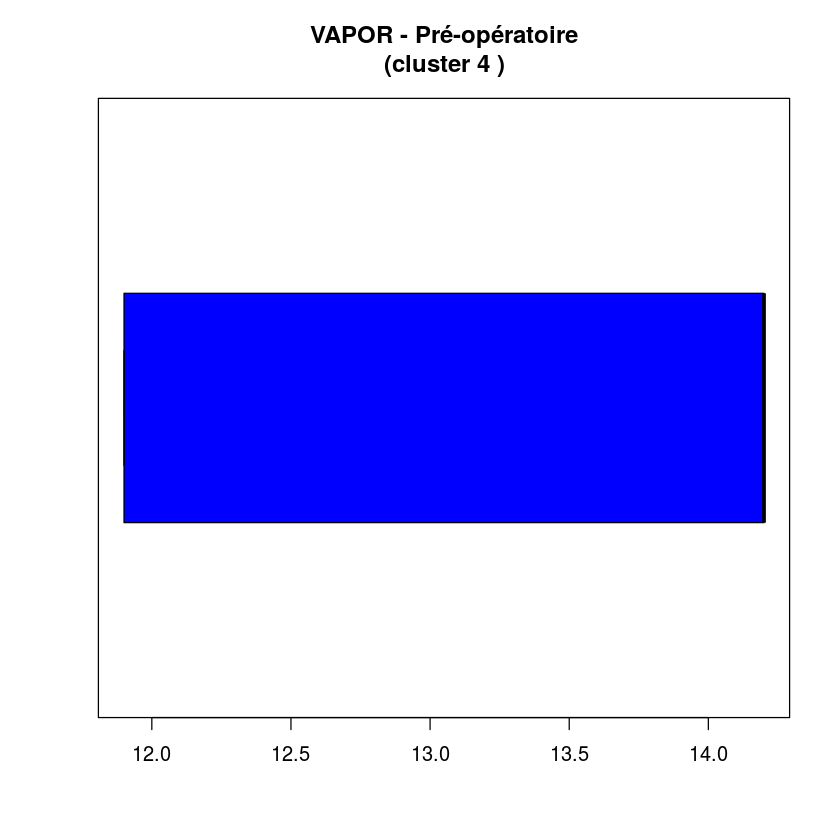

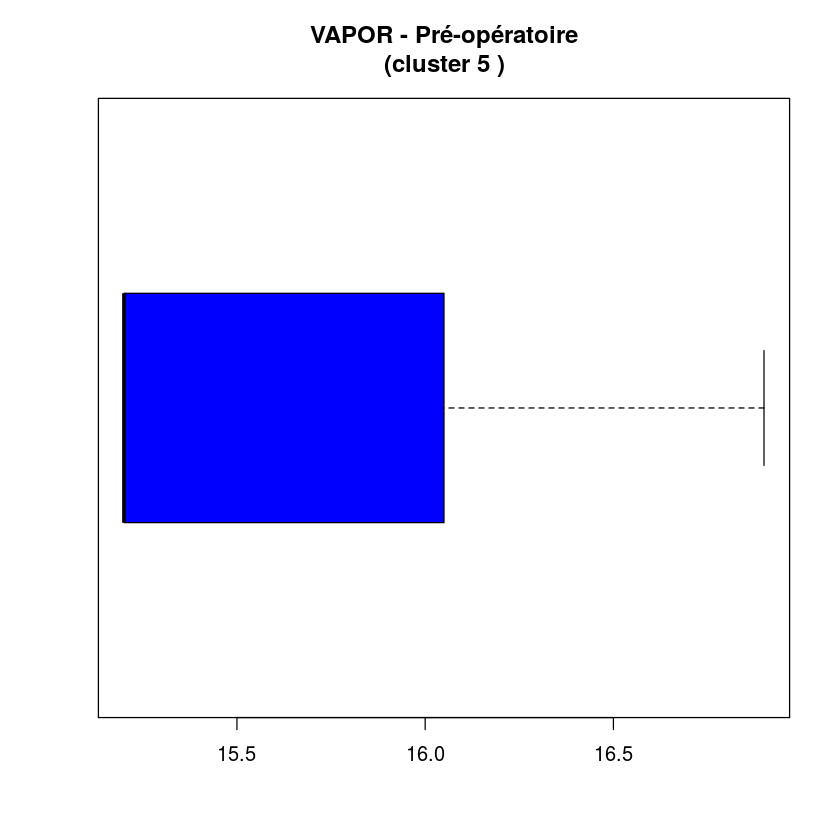

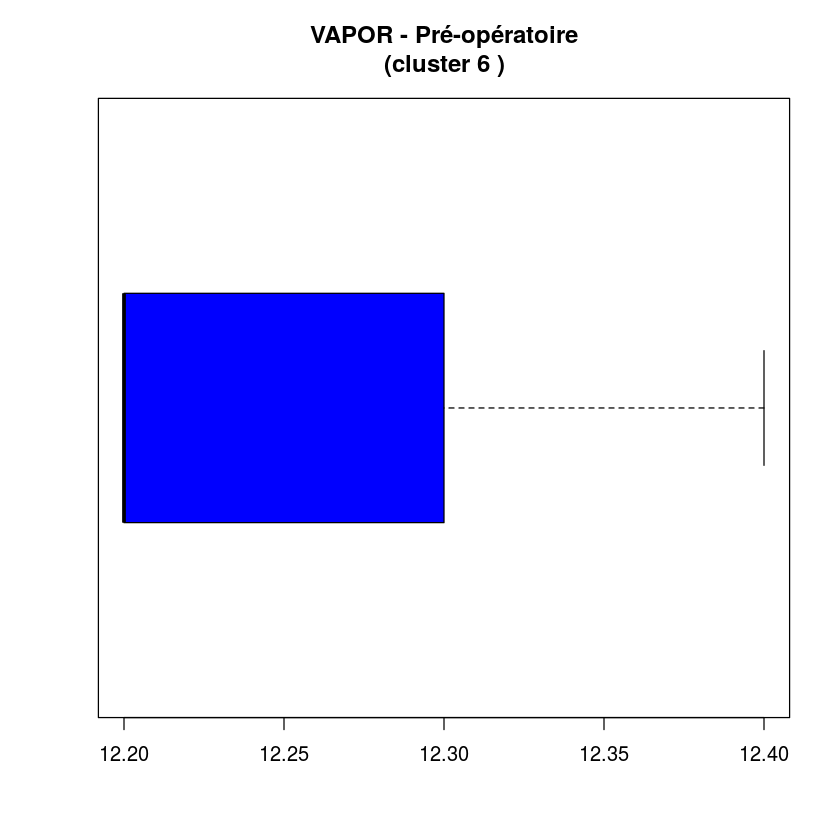

In [42]:
clusters=respam_optimal_pre$clustering
for(i in 1:k.optimal_pre){
    clust=which(clusters==i)
    boxplot(vapor_post[clust,15],
            names=c("VAPOR"),horizontal=TRUE,main=paste("VAPOR - Pré-opératoire\n(cluster", i, ")"), col=c("blue","red","#009900"))
    
    }


## 2.2 Extraction des profils types des patients à partir des données post-opératoires
### 2.2.1 PAM

Dans cette partie on va chercher  à créer des clusters de profils types de guérison à partir des données post-opératores. On fait une classification non supervisée avec PAM ensuite une CAH pour valider les résultats. 
Pour cette étape on choisit de changer le type de QoL et de le mettre en numérique àfin de créer des séries temporelles.On crée trois séries temporelles une pour QoL , une pour Qmax et une dernière pour Ipss . Ces séries représentent l'évolution de ces variables à travers les 18 mois après l'opération. 

Une fois que nos séries sont mises en place en fait Pam en utilisant dist  pour calucler nos distances entre les séries temporelles et en prenant comme méthode la méthode euclidienne permettant de faire des comparaisons sur les mêmes périodes temporelles.


In [27]:
#On crée une matrice de séries temporelles
vapor_cat_post$X1M_QoL<-as.numeric(vapor_cat_post$X1M_QoL)
vapor_cat_post$X3M_QoL<-as.numeric(vapor_cat_post$X3M_QoL)
vapor_cat_post$X6M_QoL<-as.numeric(vapor_cat_post$X6M_QoL)
vapor_cat_post$X9M_QoL<-as.numeric(vapor_cat_post$X9M_QoL)
vapor_cat_post$X12M_QoL<-as.numeric(vapor_cat_post$X12M_QoL)
vapor_cat_post$X15M_QoL<-as.numeric(vapor_cat_post$X15M_QoL)
vapor_cat_post$X18M_QoL<-as.numeric(vapor_cat_post$X18M_QoL)
vapor_cat_post_QoL=t(vapor_cat_post)
vapor_cat_post_series_QoL=ts(vapor_cat_post_QoL, start=1,deltat=3)
matrix_series=matrix(NA,ncol=21)
matrix_series=cbind(t(vapor_num_post_series_qmax),t(vapor_num_post_series_ipss))
matrix_series=cbind(matrix_series,(t(vapor_cat_post_series_QoL)))

In [43]:

#On crée une matrice de dissimilarité utilisant la distance euclidienne
disMatrix=dist(matrix_series , method="euclidean")
#On fait une boucle pour repèrer les 5 meilleurs valeurs de k qui maximise la valeur silhouette
respam<- numeric(20)
for (k in 2:11)
respam[[k]] <- pam(disMatrix,k) $ silinfo $ avg.width
sortrespam=respam[which(respam>0.7)]
sortrespam=sort(sortrespam,decreasing=TRUE)
for (i in 1:5){
    if(i <= length(sortrespam))
    k.best[i] <-which(respam[]==sortrespam[i])
}
#On regarde le min de k pour une valeur silhouette supérieur à 0.7
k.min<-min(k.best)
cat("Les 5 meilleurs nombre de clusters sont", k.best, ".Ayant une valeur silhouette de ",respam[k.best[1]]," pour un nombre de cluster=" ,k.best[1]," . \n")
cat("Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est", k.min, " et ayant un valeur silhouette de ",respam[k.min],"\n")

Les 5 meilleurs nombre de clusters sont 11 10 6 3 9 10 .Ayant une valeur silhouette de  0.8018298  pour un nombre de cluster= 11  . 
Le nombre minimal de clusters pour une valeur silhouette supérieure à 0.7 est 3  et ayant un valeur silhouette de  0.7438339 


In [29]:
k.optimal=k.min

On choisit le minimum de classes c'est à dire trois classes puis on fait la CAH afin de valider le résultat trouvé.

### 2.2.2 CAH

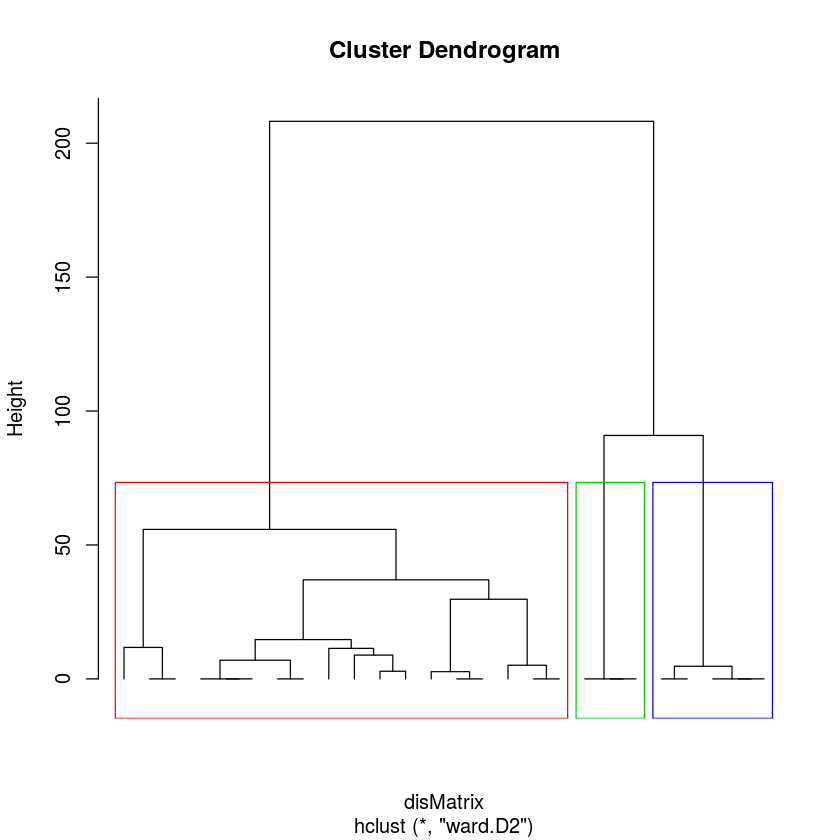

In [30]:
resuhc <- hclust(disMatrix, method = "ward.D2")
# Visualization de resuhc
plot(resuhc, labels = FALSE, hang = -1)
# Ajout des rectangles autour des clusters
rect.hclust(resuhc, k = k.optimal, border = 2:4) 

Ainsi en faisant la CAH on remarque que les classes ne sont pas trés homogènes. Le nombre d'individus est trés différent d'une classe à une autre. Ainsi on peut faire une étude cah pour un cluster=6.

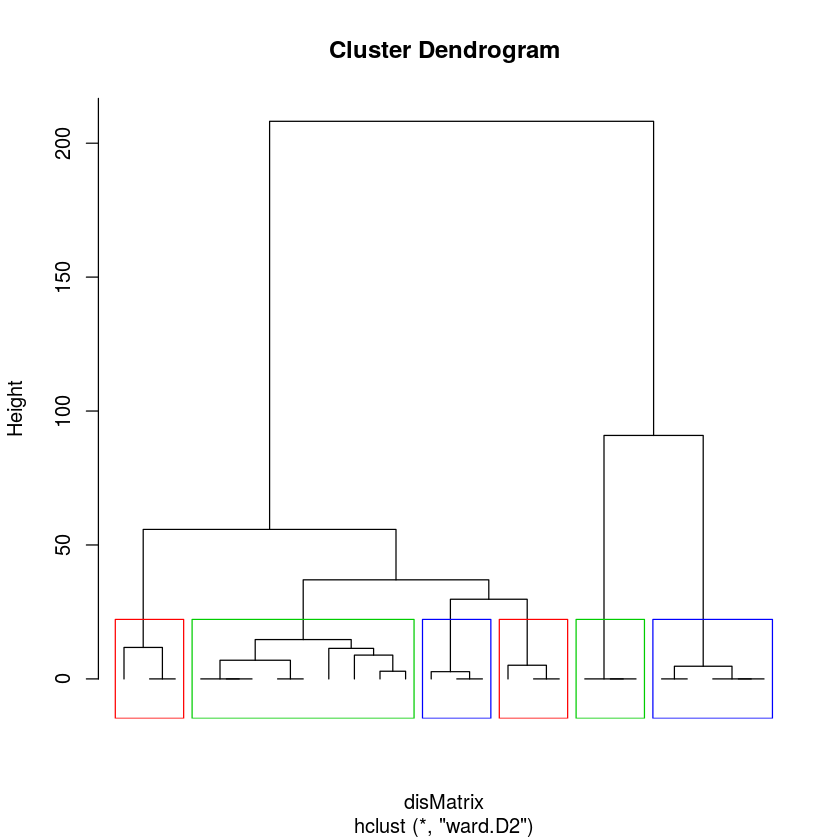

In [31]:
k.optimal=6
plot(resuhc, labels = FALSE, hang = -1)
# Ajout des rectangles autour des clusters
rect.hclust(resuhc, k = k.optimal, border = 2:4) 

La CAH permet de bien valider le nombre de clusters trouvé en faisant l'étude PAM. Ainsi on retrouve 6 classes différentes.

### 2.2.3 Caractérisation des patients médoids

Afin de bien voir la différence entre les médoids on choisit de dessiner les séries temporelles représentant les 3 variables pour les 6 médoids retrouvés précédemment.

Medoids:
     ID       
[1,] "23" "37"
[2,] "21" "34"
[3,] "25" "39"
[4,] "6"  "11"
[5,] "20" "33"
[6,] "19" "32"
Clustering vector:
 3  5  7  9 10 11 12 13 14 20 21 22 23 24 25 27 30 31 32 33 34 36 37 38 39 40 
 1  2  1  3  1  4  1  5  6  3  1  4  1  5  6  1  3  2  6  5  2  3  1  4  3  1 
Objective function:
   build     swap 
2.626992 2.537120 

Available components:
[1] "medoids"    "id.med"     "clustering" "objective"  "isolation" 
[6] "clusinfo"   "silinfo"    "diss"       "call"      


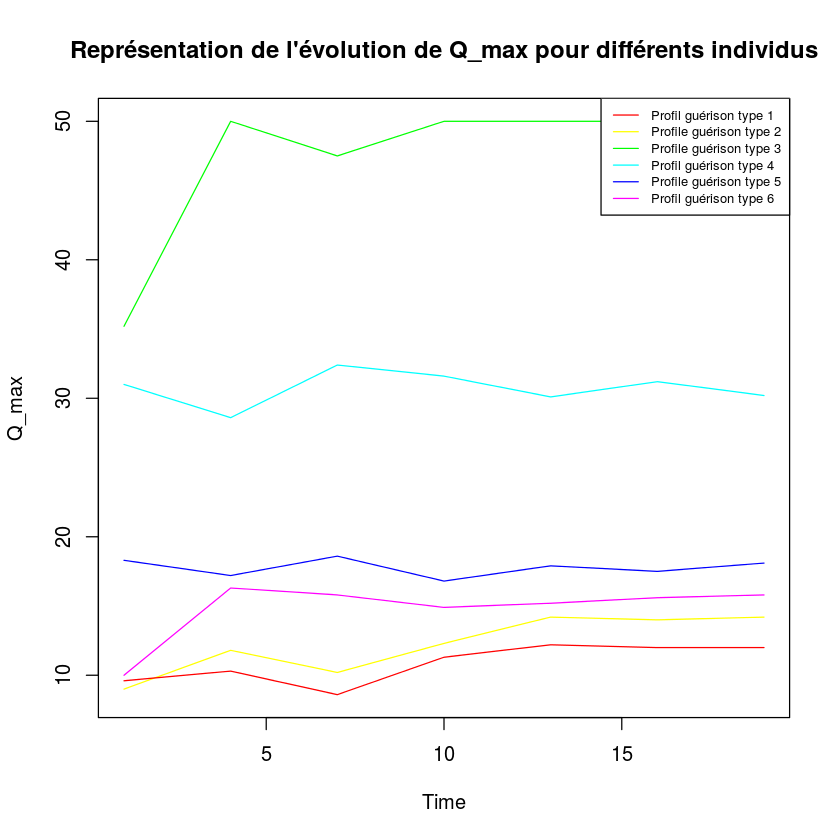

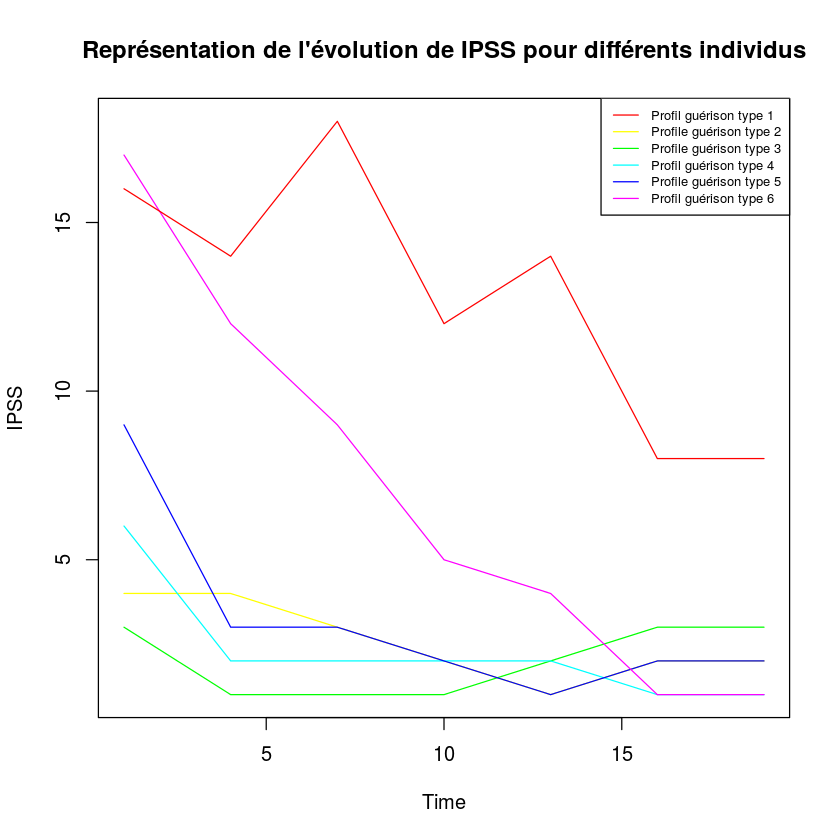

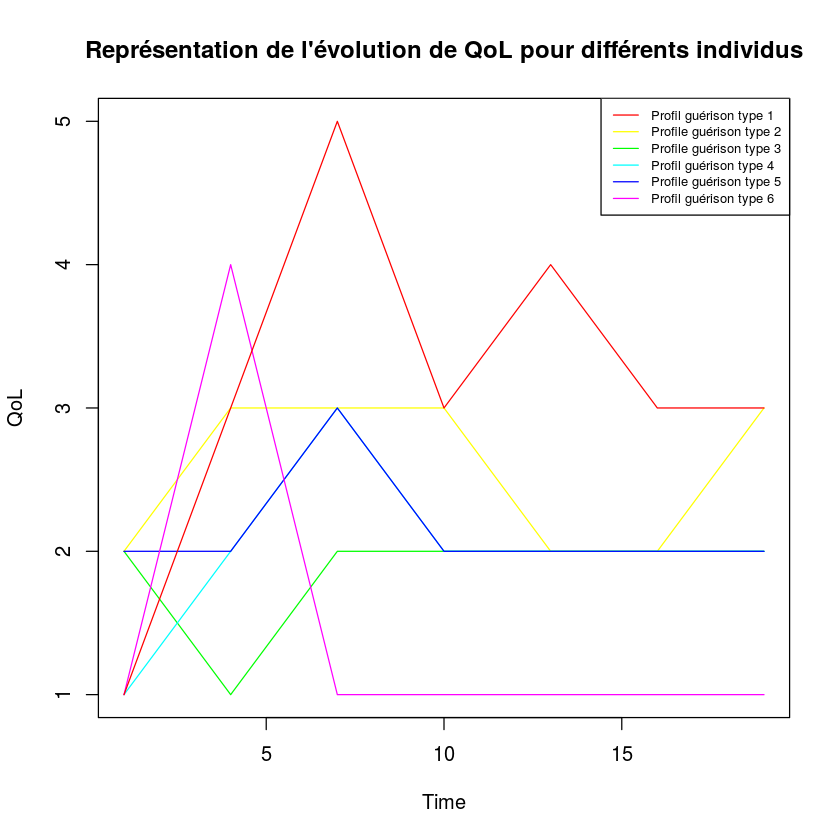

In [32]:
#Indication des médoids
medoid_post=c()
Q_max_medoids=matrix(NA)
Ipss_medoids=matrix(NA)
QoL_medoids=matrix(NA)
medoids_post=pam(disMatrix,k=k.optimal)$medoids
print(pam(disMatrix,k=k.optimal))
resdtw=matrix(NA)
for (i in 1:length(medoids_post)){
    medoid_post=rbind(medoid_post,vapor_post[medoids_post[i],])
    Q_max_medoid=vapor_num_post_series_qmax[,medoids_post[i]] 
    Ipss_medoid=vapor_num_post_series_ipss[,medoids_post[i]] 
    QoL_medoid=vapor_cat_post_series_QoL[,medoids_post[i]] 
    Q_max_medoids=cbind(Q_max_medoids,Q_max_medoid)
    Ipss_medoids=cbind(Ipss_medoids,Ipss_medoid)
    QoL_medoids=cbind(QoL_medoids,QoL_medoid)
}

ts.plot(Q_max_medoids,gpars= list(col=rainbow(6)),ylab= "Q_max",main="Représentation de l'évolution de Q_max pour différents individus")
legend("topright", c("Profil guérison type 1" ,"Profile guérison type 2","Profile guérison type 3","Profil guérison type 4","Profile guérison type 5","Profil guérison type 6"), col=rainbow(6), lty=1, cex=.65)
ts.plot(Ipss_medoids,gpars= list(col=rainbow(6)),ylab= "IPSS",main="Représentation de l'évolution de IPSS pour différents individus")
legend("topright", c("Profil guérison type 1" ,"Profile guérison type 2","Profile guérison type 3","Profil guérison type 4","Profile guérison type 5","Profil guérison type 6"), col=rainbow(6), lty=1, cex=.65)
ts.plot(QoL_medoids,gpars= list(col=rainbow(6)),ylab= "QoL",main="Représentation de l'évolution de QoL pour différents individus")
legend("topright", c("Profil guérison type 1" ,"Profile guérison type 2","Profile guérison type 3","Profil guérison type 4","Profile guérison type 5","Profil guérison type 6"), col=rainbow(6), lty=1, cex=.65)

#### Pour la classe 1 des profils de guérison :
On remarque que le pic de QoL a une valeur de 4 au niveau du 7ième mois. c'est le plus atteint le plus en retard parmi ceux de toutes les classes. On remarque que pendant cette période un pic d'IPSS est également relevé. Ceci s'explique par l'augmentation des symptômes qui font que le patient se sent mal. Par contre  ces valeurs se voient diminuer progressivement jusqu'au bout de 18 mois où QoL atteint une valeur de 2. 

#### Pour la classe 2 des profils de guérison :
Au niveau de cette classe on remarque une valeur QoL de 3 au niveau des premiers mois et qui diminue progressivement pour atteindre une valeur de 1 au 15ième mois et augmenter lègèrement à 2 au 18ième mois. Le fait que la Qol ne cesse de diminuer s'explique par le fait que l'IPSS soit représenté par une courbe décroissante.
#### Pour la classe 3 des profils de guérison :
Au sein de cette classe on remarque une diminution rapide du QoL. Cette variable passe de 3 à 1 au bout de 4ième mois puis stagne à 1. Ceci s'explique par le fait que l'IPSS diminue au bout du 4ième mois puis voit une petite augmentation pour atteindre une valeur de 3.
#### Pour la classe 4  et 5 des profils de guérison :
Ces deux classes ont quasiment une même évolution sauf que pour la classe 5 le niveau de Qol débute avec une valeur de 3 puis au bout du 5ième mois atteint une valeur de 2 et coïncide ac la classe 4 qui commence avec une Qol égale à 2. Au bout du 8ième mois les deux valeurs diminuent progressivement pour stagner vers une valeure égale à 1 vers le 10ième mois. En effet les patients de ces deux classes guérissent progressivement.

#### Pour la classe  6 des profils de guérison :
Pour cette classe on a l'impression que les individus guérissent le plus rapidement possible. On voit un pic de QoL vers 5 mois puis une diminution rapide pour atteindre un QoL de 0 et rester à 0 à partir du 7ième mois.

### 2.2.4 Distribution des profils de guérisons

Suites aux études faites précédemment on peut trés bien voir la distribution des profils de guérisons par types de patients. 

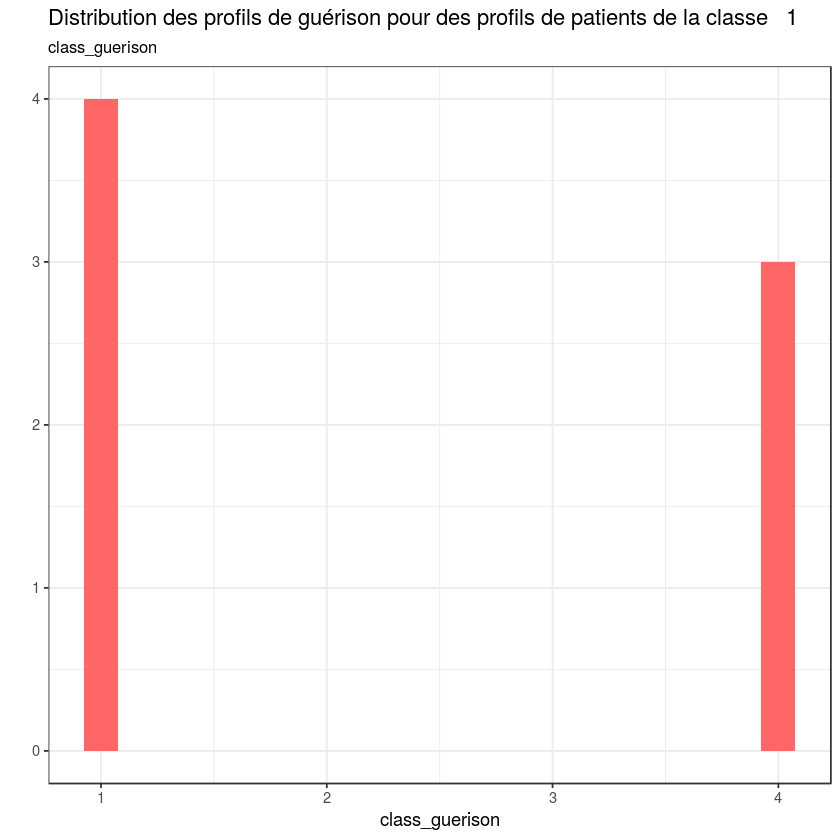

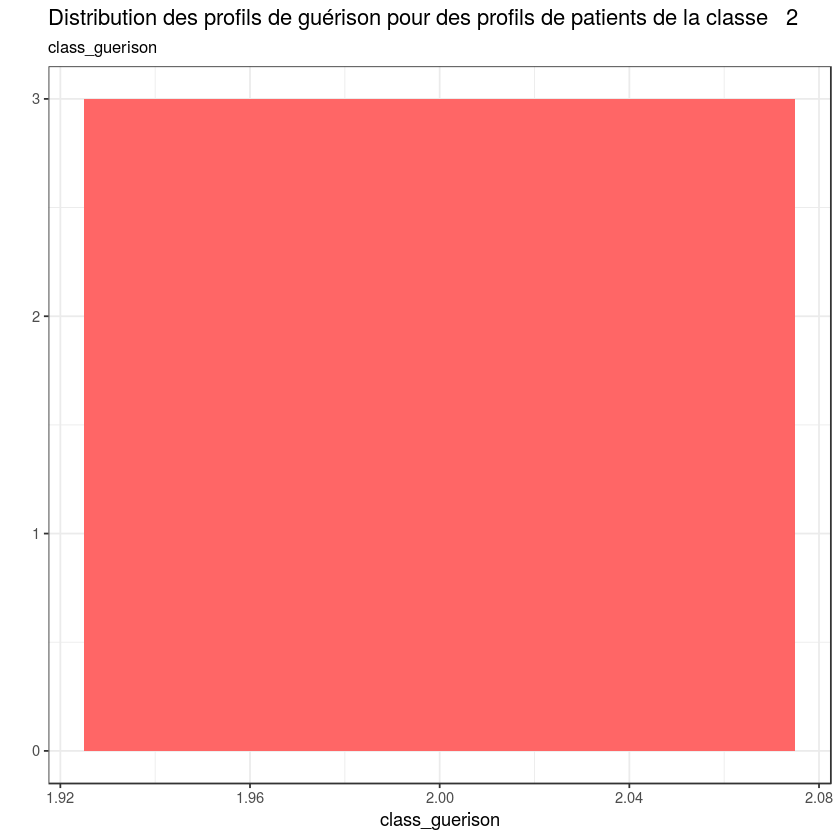

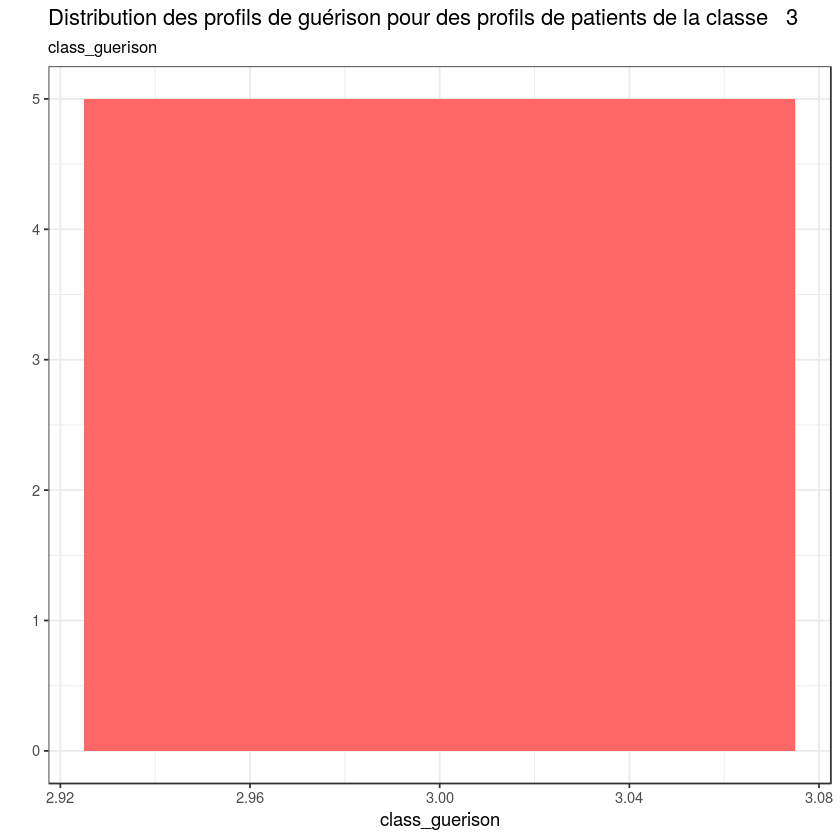

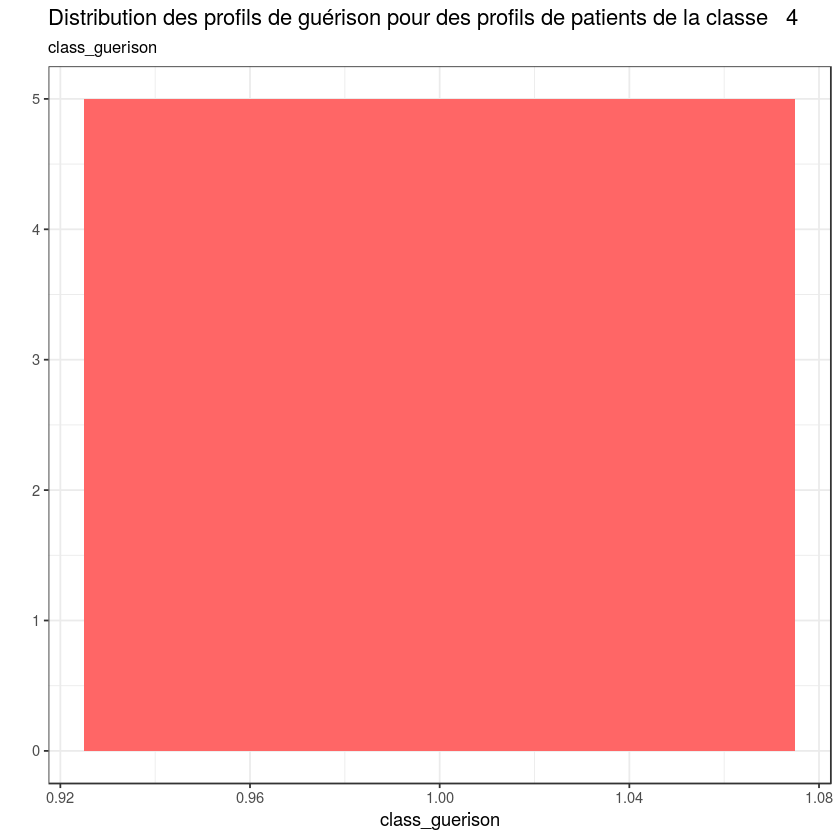

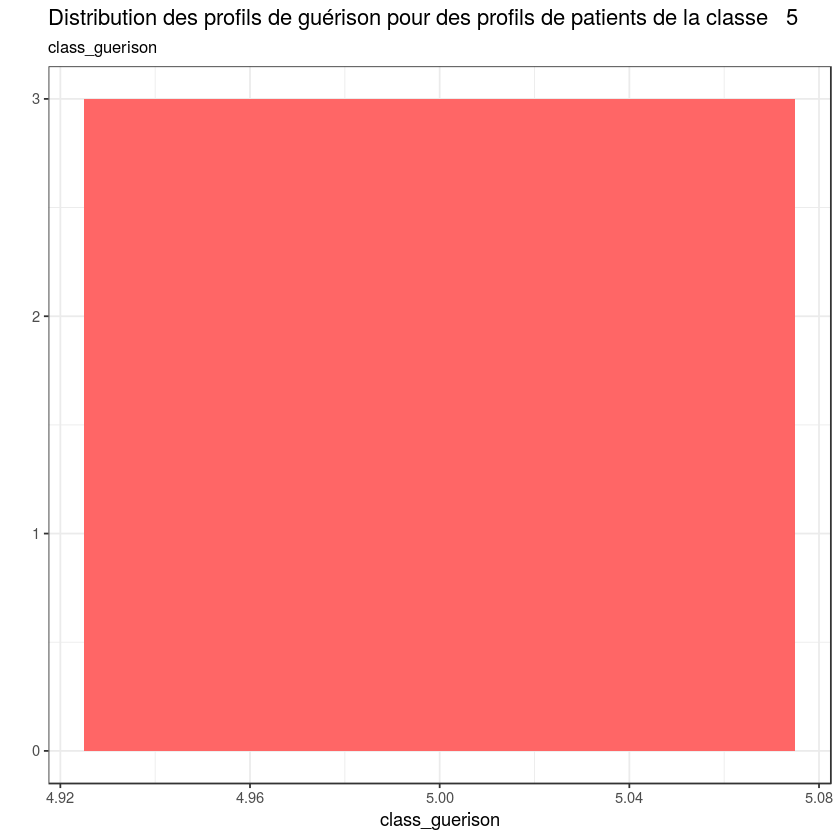

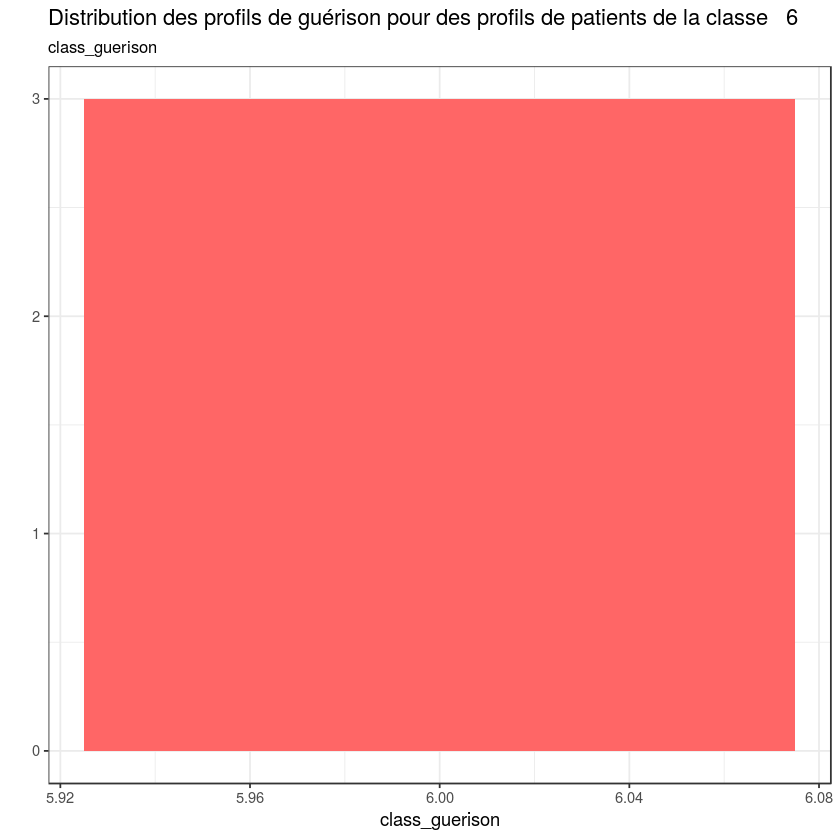

In [33]:
respam=pam(disMatrix,k.optimal)
vapor_post_clus<-data.frame(vapor,respam$clustering)
class=c()  
for (i in 1:length(medoids_pre)){
    class=which(respam_optimal_pre$clustering==i)  
    class_guerison=vapor_post_clus$respam.clustering[class]
    df=data.frame(class_guerison)
    adenome_barplot(df,1,paste("Distribution des profils de guérison pour des profils de patients de la classe  ", i))
    }
# md[i]=which(vapor_post_clus$respam.clustering==medoids_pre[i])

Ainsi à travers les barplots ci-dessus on remarque que: 

#### Pour la classe 1 des patients: 
-Il y a deux types de guérison. Soit le type de guérison représenté par la classe 1 ou le profil représenté par la classe 4. En effet cette classe de patients représente des individus moyennement agés qui ont une durée de traitement médical assez grande et un résidu post mictionnel trés grand. Ces individus ne voient pas la disparition total des symptômes car avec les deux profils types de guérisons on voit une diminution jusqu'à atteindre un Qol d'une valeur de 1 ou 2. 

#### Pour la classe 2, 3, 4, 5 et 6 des patients:
On remarque que ces classes sont plus homogènes : pour toute la classe on retrouve un seul profil guérison correspondant à tous les individus. 

Cependant pour :

-La classe 2 des patients. Le profil de guérison est celui représenté par la classe 2. En effet les patients sont moyennement agés avec une durée de traitement médical trés faible et un volume réséqué trés grand et la guérison se fait progresivement mais le patient ne ressent une amélioration qu'à partir du 15ième mois.

-La classe 3 des patients. Le profil de guérison est celui représenté par la classe 3. Les patients de cette classe sont agés avec un volume réséqué et une durée de traitement faibles. Ces profils voient une guérison rapide avec un Qol qui stagne à une valeur de 1. Ce qui montre que les patients se sentent rapidement assez bien après l'opération.

-La classe 4 des patients. Le profil de guérison est celui représenté par la classe 4. La classe représente des individus agés avec un volume prostatique trés grand et un résidu post mictionnel trés grand. Ces patients commencent à guérir au bout du 7ième mois mais ne constatent une réelle amélioration qu'au bout du 12 ième mois apès l'opération.  

-La classe 5  des patients. Le profil de guérison est celui représenté par la classe 5. Dans cette classe les individus sont agés avec un volume prostatique moyen et un résidu post mictionnel à zéro. Ces individus guérissent progresivement et ne ressenttent une réelle amélioration qu'à partir du 10ième mois. 

-La classe 6  des patients. Le profil de guérison est celui représenté par la classe 6. Ceci s'explique par le fait que les jeunes patients qui ont durée de traitement trés faible ont un durée de guerison assez rapide.

# 3.Classification Supervisée

## 3.1 Arbres de régression

Tous nos arbres sont des arbres de régression car ils prédisent des variables quantitatives, y compris la variable "QoL" que nous avons choisi de traiter comme numérique malgré qu'elle soit réellement de type "ordinal".

#### a.IPSS

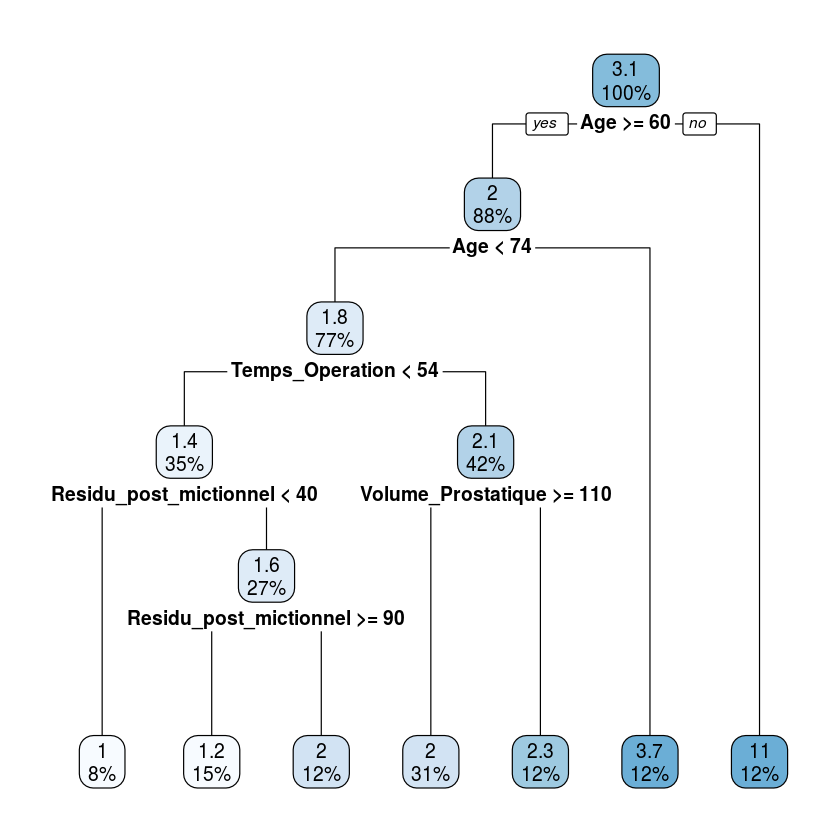

In [34]:
matrix_for_tree_IPSS=matrix(NA)
ipss=subset(vapor_num_post,select=c(X12M_IPSS))
matrix_for_tree_IPSS=cbind(vapor_num_pre,ipss)
tree_IPSS=rpart(method="anova",formula=matrix_for_tree_IPSS$X12M_IPSS ~.,data=matrix_for_tree_IPSS,control=rpart.control(minsplit=5,cp=0))
pSimple_Ipss <- prune(tree_IPSS,cp=0)
rpart.plot(pSimple_Ipss)


Afin d'évaluer l'exactitude des résultats de l'arbre on va prendre 5 individus au hasard et voir si la valeur prédite coincide avec la valeur observé. Ci-dessous les résultats : 

In [35]:
# Evaluation de la performance de l'arbre avec 5 individus tirés au hasard
rnd_individus = sample(1:nrow(matrix_for_tree_IPSS),5)
df <- data.frame(round (predict(pSimple_Ipss,matrix_for_tree_IPSS[rnd_individus,])), matrix_for_tree_IPSS[rnd_individus,11])
colnames(df) <- c("Prédiction","Observé")
df

,Prédiction,Observé
22,2,3
32,11,14
27,1,1
30,2,2
3,2,3


On remarque que les valeurs prédites sont trés proches des valeurs observées.

#### b.Qmax

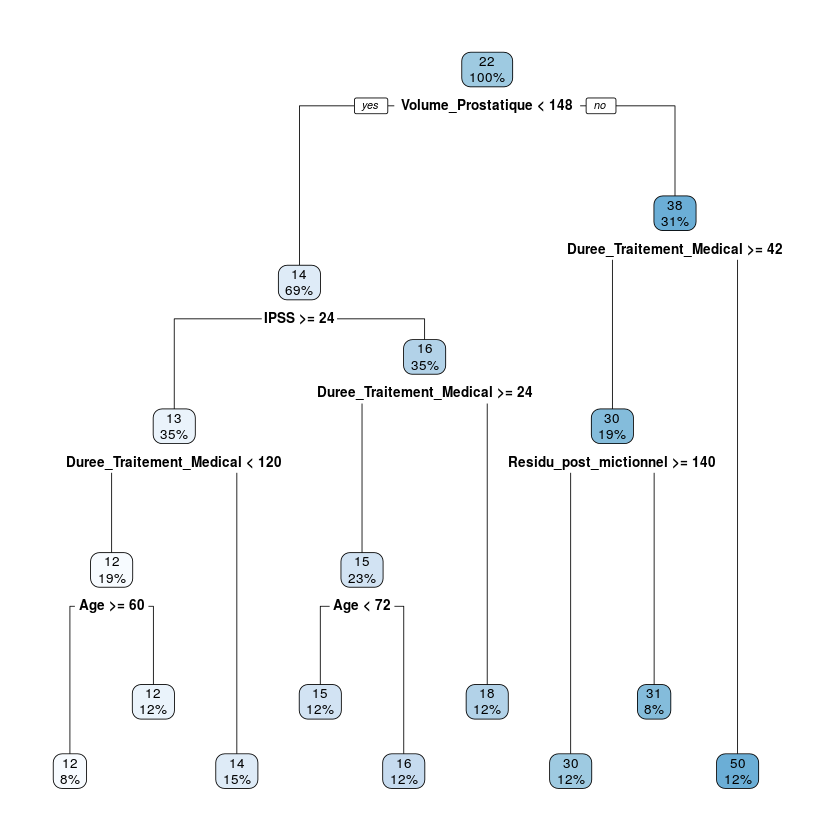

In [36]:
matrix_for_tree_Qmax=matrix(NA)
qmax=subset(vapor_num_post,select=c(X12M_Qmax))
matrix_for_tree_Qmax=cbind(vapor_num_pre,qmax)
tree_Qmax = rpart(method="anova",formula=matrix_for_tree_Qmax$X12M_Qmax ~ .,data=matrix_for_tree_Qmax,control=rpart.control(minsplit=5,cp=0))
pSimple_Qmax <- prune(tree_Qmax,cp=0)
rpart.plot(pSimple_Qmax)


Afin d'évaluer l'exactitude des résultats de l'arbre on va prendre 5 individus au hasard et voir si la valeur prédite coincide avec la valeur observée. Ci-dessous les résultats :

In [37]:
# Evaluation de la performance de l'arbre avec 5 individus tirés au hasard
rnd_individus = sample(1:nrow(matrix_for_tree_Qmax),5)
df <- data.frame(predict(pSimple_Ipss,matrix_for_tree_Qmax[rnd_individus,]), matrix_for_tree_Qmax[rnd_individus,11])
colnames(df) <- c("Prédiction","Observé")
df

,Prédiction,Observé
27,1.25000,14.2
14,11.33333,12.2
22,2.00000,17.9
36,2.00000,31.0
21,1.25000,11.9


On remarque que pour Q_max les valeurs prédites ne sont pas égales aux valeurs observés sauf pour le deuixième individu.Ainsi on peut dire que les résultats de cet arbre ne sont pas trés cohérents.

#### c.QoL

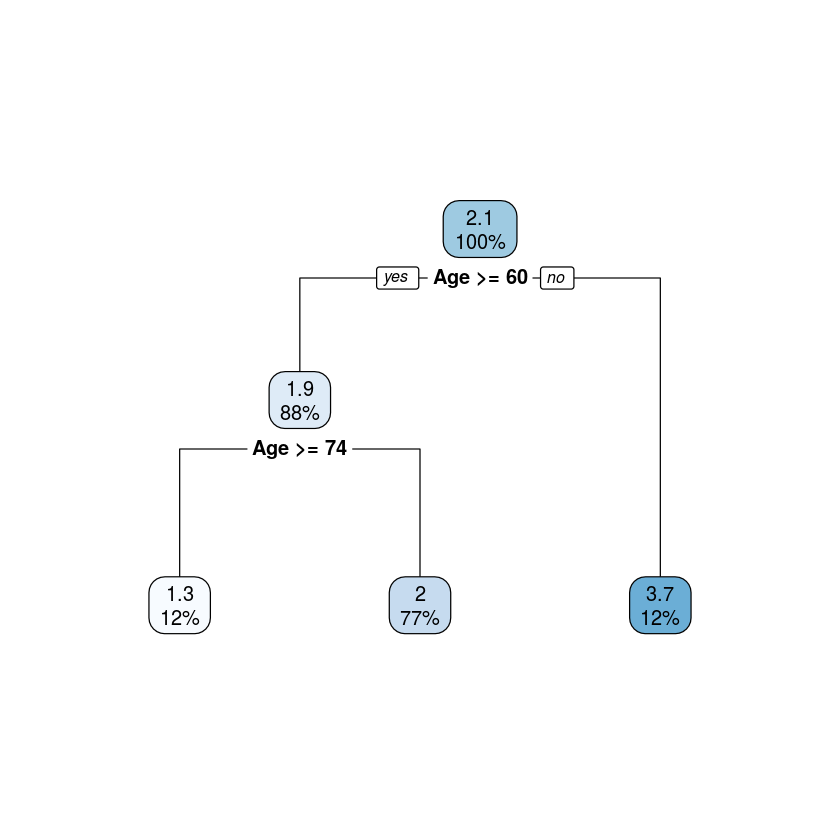

In [38]:
matrix_for_tree_QoL=matrix(NA)
qol=subset(vapor_cat_post,select=c(X12M_QoL))
matrix_for_tree_QoL=cbind(vapor_num_pre,qol)
tree_QoL = rpart(method="anova",formula=matrix_for_tree_QoL$X12M_QoL ~ .,data=matrix_for_tree_QoL,control=rpart.control(minsplit=6,cp=0))
pSimple_QoL <- prune(tree_QoL,cp=0)
rpart.plot(pSimple_QoL)

Afin d'évaluer l'exactitude des résultats de l'arbre on va prendre 5 individus au hazard et voir si la valeur prédite coincide avec la valeur observé. Ci-dessous les résultats :

In [39]:
# Evaluation de la performance de l'arbre avec 5 individus tirés au hasard
rnd_individus = sample(1:nrow(matrix_for_tree_Qmax),5)
df <- data.frame(predict(pSimple_Ipss,matrix_for_tree_QoL[rnd_individus,]), matrix_for_tree_QoL[rnd_individus,11])
colnames(df) <- c("Prédiction","Observé")
df

,Prédiction,Observé
38,1.25000,2
30,2.00000,2
31,2.00000,2
22,2.00000,2
25,11.33333,3


## 3.2 Prédiction des classes de guérisons

L'idée ici est de reprendre la classification de guérison et de créer un arbre de décision basé sur les variables pré-opératoire permettant de prédire cette classification.
On parlera d'arbre de classification car la variable à prédire est une classe (variable qualitative donc).

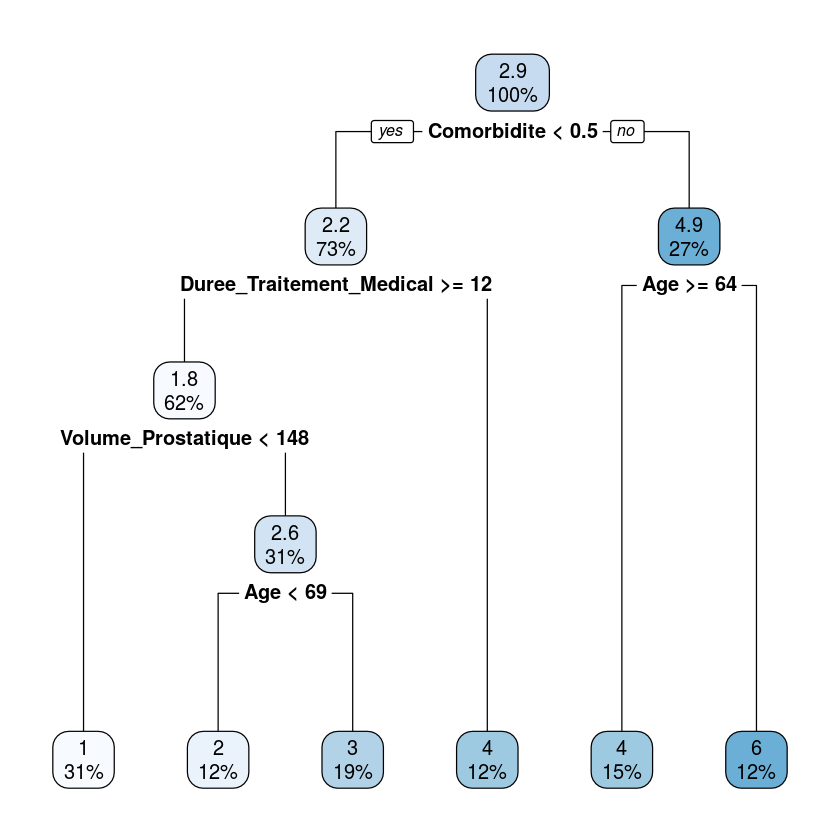

In [40]:
vapor_pre_clus<-data.frame(vapor_pre,respam$clustering)
tree_cluster = rpart(method="anova",formula=vapor_pre_clus$respam.clustering~ .,data=vapor_pre_clus,control=rpart.control(minsplit=6,cp=0))
pSimple_clus <- prune(tree_cluster,cp=0)
rpart.plot(pSimple_clus)

In [44]:
# Evaluation de la performance de l'arbre avec 5 individus tirés au hasard
rnd_individus = sample(1:nrow(vapor_pre_clus),5)
df <- data.frame( round (predict(pSimple_Ipss,vapor_pre_clus[rnd_individus,])), vapor_pre_clus[rnd_individus,19])
colnames(df) <- c("Prédiction","Observé")
df

,Prédiction,Observé
11,2,4
21,1,1
12,2,1
25,11,6
10,1,1


Ainsi on remarque que l arbre  n'est pas trés performant. Seules 2 classes sur 5 ont été prédites correctement.